# Imports

In [1]:
import os
import glob
import math
import re
from collections import Counter
import numpy as np
import pandas as pd
import scipy
from scipy.sparse import issparse, csr_matrix
from scipy import stats, sparse, spatial
from scipy.stats import (
    kruskal, mannwhitneyu, pearsonr, fisher_exact, combine_pvalues
)
from statsmodels.stats.multitest import multipletests
from sklearn import cluster
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import gridspec, font_manager as fm
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import scanpy as sc
import anndata as ad
import gseapy as gp
from shapely.geometry import (
    MultiPoint, LineString, Polygon, Point, JOIN_STYLE
)
from shapely.ops import polygonize, unary_union
from shapely.affinity import scale
from shapely.prepared import prep
from scipy.spatial import Delaunay, cKDTree
from scipy.sparse.csgraph import connected_components

## Merge RCTD cell type w/ Curio H5ad

In [2]:
samples = [
    {
        "run": "rl_batista_filemove",
        "puck": "C85_32",
        "date": "2025-04-30",
        "puck_name": "Puck_250122_32",
    },
    {
        "run": "rl_batista_filemove",
        "puck": "C85_33",
        "date": "2025-04-30",
        "puck_name": "Puck_250122_33",
    },
    {
        'run': '250828_RL_PCGC',
        'puck': 'C85_7',
        'date': '2025-07-25',
        'puck_name': 'Puck_250122_07'
    },
    
    {
        'run': '250828_RL_PCGC',
        'puck': 'C85_14',
        'date': '2025-07-25',
        'puck_name': 'Puck_250122_14'
    }
]

In [3]:
def process_RCTD(adata_file, rctd_file, weights_file):
    '''
    Takes RCTD cell type calling outputs and appends cell type data to AnnData object.
    
    Parameters:
    - adata_file: AnnData object
    - rctd_file: tsv file with cell type information that maps barcode to cell type
    - weights_file: tsv file that maps barcodes to cell type weight
    
    Returns:
    - `"spot_class"` : RCTD classification of spot.
    - `"first_type"` : top predicted cell type per spot.
    - `"second_type"` : second predicted cell type per spot.
    - `"first_weight"` : weight (proportion) for the top predicted cell type.
    - `"second_weight"` : weight (proportion) for the second predicted cell type.
    '''
    rctd_file.set_index("Unnamed: 0", inplace=True)
    adata_file.obs = adata_file.obs.merge(
        rctd_file[["spot_class", "first_type", "second_type"]],
        left_index=True,
        right_index=True,
        how="left",
    )

    first_type = adata_file.obs.first_type.tolist()
    second_type = adata_file.obs.second_type.tolist()
    bcs = adata_file.obs.index.tolist()

    weights_file.set_index("Unnamed: 0", inplace=True)

    celltype = list(weights_file.columns)
    weights_array = weights_file.to_numpy()
    bc2celltype2weights = {}
    for i, bc in enumerate(weights_file.index.tolist()):
        bc2celltype2weights[bc] = {
            celltype[j]: weights_array[i][j] for j in range(len(celltype))
        }

    first_weight = []
    second_weight = []
    for i, bc in enumerate(bcs):
        if first_type[i] in celltype:
            first_weight.append(bc2celltype2weights[bc][first_type[i]])
            second_weight.append(bc2celltype2weights[bc][second_type[i]])
        else:
            first_weight.append(first_type[i])
            second_weight.append(second_type[i])

    adata_file.obs["first_weight"] = first_weight
    adata_file.obs["second_weight"] = second_weight
    return adata_file

In [4]:
for sample in samples:
    run_name    = sample["run"]
    puck_id     = sample["puck"]
    sample_date = sample["date"]
    puck_details= sample["puck_name"]

    adata = sc.read_h5ad(
        f"/data/liulab/software/curioseeker-v3.0.0/pipeline_outputs/"
        f"{run_name}/results/OUTPUT/{puck_id}/{puck_id}_anndata.h5ad"
    )
    bcxy = pd.read_csv(
        f"/data/liulab/software/curioseeker-v3.0.0/pipeline_outputs/"
        f"{run_name}/results/OUTPUT/{puck_id}/{puck_id}_MatchedBeadLocation.csv"
    )
    bcxy.columns = ["bc", "x", "y"]
    adata.obs = adata.obs.merge(bcxy.set_index("bc"), left_index=True, right_index=True)
    adata.var.columns = ["gene"]

    base_dir     = "/data/liulab/kevin/RCTD_output"
    dir_prefix   = f"curio_{sample_date}_{puck_details}_RCTD"
    file_prefix  = f"curio_{sample_date}_{puck_details}"

    candidate_dirs = [os.path.join(base_dir, f"{dir_prefix}_RCTD"),
                      os.path.join(base_dir, dir_prefix),
                      os.path.join(base_dir, file_prefix)]

    rctd_file = weights_file = None
    chosen_dir = None

    for rdir in candidate_dirs:
        if not os.path.isdir(rdir):
            continue
        rf = os.path.join(rdir, f"{file_prefix}_output.csv")
        wf = os.path.join(rdir, f"{file_prefix}_norm_weights.csv")
        if os.path.exists(rf) and os.path.exists(wf):
            rctd_file, weights_file, chosen_dir = rf, wf, rdir
            break
        # Fallback: glob for the two files if exact names don’t match
        cand_rf = glob.glob(os.path.join(rdir, "*_output.csv"))
        cand_wf = glob.glob(os.path.join(rdir, "*_norm_weights.csv"))
        if cand_rf and cand_wf:
            rctd_file, weights_file, chosen_dir = cand_rf[0], cand_wf[0], rdir
            break

    if rctd_file is None:
        tried = "\n  ".join(candidate_dirs)
        raise FileNotFoundError(
            f"RCTD outputs not found for {puck_id} ({sample_date}). Tried:\n  {tried}"
        )

    rctd    = pd.read_csv(rctd_file)
    weights = pd.read_csv(weights_file)

    processed_results = process_RCTD(adata, rctd, weights)
    var_name = f"{puck_id}_adata"
    globals()[var_name] = processed_results

    out_filename = f"{puck_id}_processed.h5ad"
    processed_results.write(out_filename)
    
    print(f"Loaded RCTD as `{var_name}` from file: {rctd_file}")

Loaded RCTD as `C85_32_adata` from file: /data/liulab/kevin/RCTD_output/curio_2025-04-30_Puck_250122_32_RCTD_RCTD/curio_2025-04-30_Puck_250122_32_RCTD_output.csv
Loaded RCTD as `C85_33_adata` from file: /data/liulab/kevin/RCTD_output/curio_2025-04-30_Puck_250122_33_RCTD_RCTD/curio_2025-04-30_Puck_250122_33_RCTD_output.csv
Loaded RCTD as `C85_7_adata` from file: /data/liulab/kevin/RCTD_output/curio_2025-07-25_Puck_250122_07_RCTD_RCTD/curio_2025-07-25_Puck_250122_07_RCTD_output.csv
Loaded RCTD as `C85_14_adata` from file: /data/liulab/kevin/RCTD_output/curio_2025-07-25_Puck_250122_14_RCTD/curio_2025-07-25_Puck_250122_14_output.csv


# h5ad processing

In [5]:
# download h5ads from the Broad Institute's Single Cell Portal
C85_33_adata = sc.read_h5ad("C85_33_adata.h5ad")
C85_32_adata = sc.read_h5ad("C85_32_adata.h5ad")
C85_7_adata = sc.read_h5ad("C85_7_adata.h5ad")
C85_14_adata = sc.read_h5ad("C85_14_adata.h5ad")

# C85_33 (d6 I3-3)

## Helper Functions

In [6]:
def add_scale_bar(ax):
    fontprops = fm.FontProperties(size=10)
    plt.rcParams.update({"pdf.fonttype": 42, "ps.fonttype": 42})

    # 500μm scale
    pixels_needed = 500 / 0.65  

    scalebar = AnchoredSizeBar(
        ax.transData,
        pixels_needed,
        "500μm",
        "lower right",
        pad=0.1,
        color="black",
        frameon=False,
        size_vertical=1,
        fontproperties=fontprops,
    )
    ax.add_artist(scalebar)    

In [7]:
def save_figure(title):
    filename = re.sub(r"[^\w\s]", "", title).replace(" ", "_").lower()
    save_path = f"{filename}.png"
    save_pdf = f"{filename}.pdf"
    plt.savefig(save_path, bbox_inches="tight")
    plt.savefig(save_pdf, bbox_inches="tight")

    print(f"Figure saved as: {save_path}")

## Tissue Filtering

In [8]:
def umi_filtering(adata_file, fig_title=None):
    """
    Filter out beads with low UMI counts and plot results.
    
    Parameters:
    - adata_file: AnnData object
    - fig_title: Title of saved figure
    
    Returns:
    - points : ndarray of shape (N, 2)
        Array of (x, y) coordinates of beads that pass the UMI filter.
    - umi_mask : pandas.Series (bool)
        Boolean mask of length `adata.n_obs`, True for beads that passed the filter.
    - x_all : ndarray of shape (N,)
        X coordinates of beads that passed the filter.
    - y_all : ndarray of shape (N,)
        Y coordinates of beads that passed the filter.
    """

    # UMI quality control filtering
    adata_file.obs["umi_filtered"] = (adata_file.obs["log_umi"] > 2).astype(str)
    
    umi_mask = adata_file.obs["umi_filtered"] == "True"
    x_all = np.array(adata_file.obs.loc[umi_mask, "x"])
    y_all = np.array(adata_file.obs.loc[umi_mask, "y"])
    points = np.column_stack((x_all, y_all))
    
    fig, ax = plt.subplots()
    ax.scatter(adata_file.obs.x, adata_file.obs.y, s=0.5, color="lightgrey")
    ax.scatter(x_all, y_all, c="black", s=0.5)
    ax.set_xlim([0, 5000])
    ax.set_ylim([0, 5000])
    ax.set_aspect("equal")
    ax.set_title(fig_title)
    add_scale_bar(ax)
    ax.axis('off')

    plt.tight_layout()
    plt.show()
    
    if fig_title and isinstance(fig_title, str) and fig_title.strip():
        save_figure(fig_title)
        
    return points, umi_mask, x_all, y_all

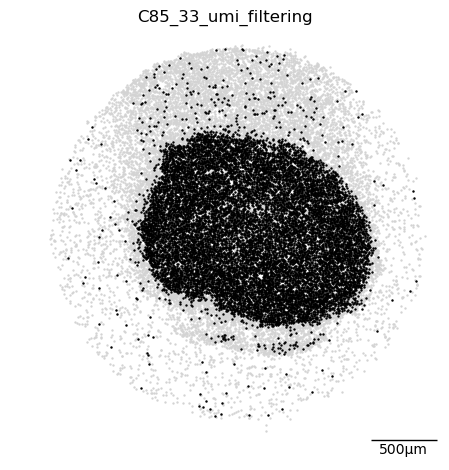

Figure saved as: c85_33_umi_filtering.png


<Figure size 640x480 with 0 Axes>

In [9]:
points, umi_mask, x_all, y_all = umi_filtering(C85_33_adata, "C85_33_umi_filtering")

In [10]:
def dbscan_filtering(adata_file, points, umi_mask, x_all, y_all, eps=35, min_samples=10, fig_title=None):
    """
    Remove beads not on tissue with DBSCAN - remove spatial outlier beads based on nearby neighbor counts from UMI filtered coordinates..
    
    Parameters:
    - adata_file: AnnData object
    - fig_title: Title of saved figure
    - points: NumPy array, UMI filtered points
    - umi_mask: boolean mask, UMI filtered points from adata
    - eps: int, DBSCAN parameter that defines maximum distance between points to be considered neighbors
    - min_samples: int, DBSCAN parameter that defines minimum number of points within eps radius
    
    Output:
    Updates `adata_file.obs` in place with a new column:
        - `"Tissue"` : string ("True"/"False") indicating whether each bead 
          passes both UMI and DBSCAN-based spatial filtering.
    """
    
    # Run DBSCAN on UMI filtered points
    db = cluster.DBSCAN(eps=eps, min_samples=min_samples)
    clusters = db.fit_predict(points)
    
    # Get coordinates that pass both UMI filtering and DBSCAN clustering
    clean_mask = clusters != -1
    x_clean = x_all[clean_mask]
    y_clean = y_all[clean_mask]
    clean_coords = set(zip(x_clean, y_clean))

    coords_mask = np.array(
        [(x, y) in clean_coords for x, y in zip(adata_file.obs["x"], adata_file.obs["y"])]
    )
    combined_mask = coords_mask & umi_mask

    adata_file.obs["Tissue"] = combined_mask.astype(str)    
    
    fig, ax = plt.subplots()
    ax.scatter(x=adata_file.obs["x"], y=adata_file.obs["y"], s=0.5, color="lightgray", label="All Cells")

    tissue_mask = adata_file.obs["Tissue"] == "True"

    ax.scatter(
        x=adata_file.obs.loc[tissue_mask, "x"],
        y=adata_file.obs.loc[tissue_mask, "y"],
        s=0.5,
        color="blue",
        label="Tissue Cells",
    )

    ax.set_title(fig_title)
    ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1))
    ax.set_aspect("equal")
    ax.axis("off")
    add_scale_bar(ax)

    plt.tight_layout()
    plt.show()

    return

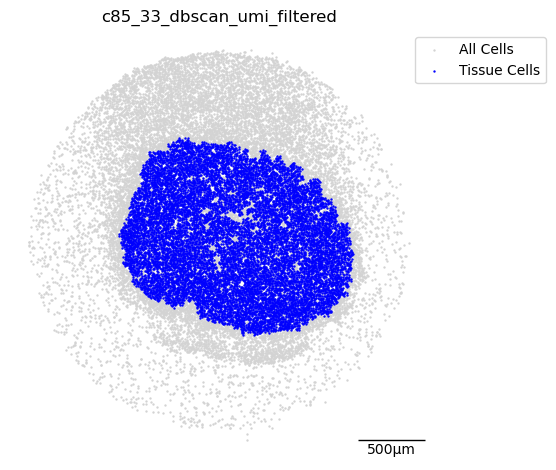

In [11]:
dbscan_filtering(C85_33_adata, points, umi_mask, x_all, y_all, fig_title="c85_33_dbscan_umi_filtered")

In [12]:
def dilate_tissue(adata_file, max_itr=10, proportion=0.5):
    """
    Performs dilation to fill in beads on tissue removed during dbscan and umi filtering
    using KNN. Iteratively adds non-tissue beads to tissue if its neighborhood is dominated by 
    beads on the tissue.
    
    Parameters:
    - adata_file: AnnData object
    - max_itr: int, how many times dilation is repeate
    - proportion: float, threshold fraction for a bead's neighbors labaled as tissue for the bead to be considered part of the tissue to be considered part of the tissue
    
    Returns
    -------
    new_indices : set of int
        Indices of beads classified as tissue after dilation. Also updates:
        - `adata_file.obs["Tissue_original"]` : preserves the pre-dilation tissue mask.
        - `adata_file.obs["indices"]` : adds numeric indices if not present.
    """
    if "indices" not in adata_file.obs.columns:
        adata_file.obs["indices"] = np.arange(adata_file.n_obs, dtype=int)


    def knn(adata_file, n_neighbors):
        x = adata_file.obs.x.to_numpy()
        y = adata_file.obs.y.to_numpy()
        xy = np.array([[x[i], y[i]] for i in range(len(x))])
        nbrs = NearestNeighbors(n_neighbors=n_neighbors + 1, algorithm="ball_tree").fit(
            xy
        )
        distances, indices = nbrs.kneighbors(xy)

        return distances, indices

    def find_enclosed(adata_file, tissue_indices):
        tissue_indices = set(tissue_indices)
        new_indices = set(tissue_indices)
        dist, ind = knn(adata_file, 30)

        for i, list_i in enumerate(ind):
            if i in tissue_indices:
                continue
            
            # Neighborhood defined as radius of 50 to original bead
            list_i = [x for x, y in zip(list_i, dist[i]) if y <= 50]

            if len([x for x in list_i[1:] if x in tissue_indices]) >= proportion * len(list_i):
                new_indices.add(i)
        return new_indices

    tissue_indices = adata_file.obs[adata_file.obs.Tissue == "True"].indices.tolist()
    old_indices = tissue_indices.copy()
    new_indices = find_enclosed(adata_file, tissue_indices)
    adata_file.obs["Tissue_original"] = adata_file.obs["Tissue"]

    tracker = 0
    while len(new_indices) != len(old_indices) and tracker <= max_itr:
        old_indices = new_indices.copy()
        new_indices = find_enclosed(adata_file, old_indices)
        tracker += 1
    
        
    return new_indices

In [13]:
dilated_indices = dilate_tissue(C85_33_adata, max_itr=10, proportion=0.5)

index_labels = C85_33_adata.obs.iloc[list(dilated_indices)].index
C85_33_adata.obs.loc[index_labels, "Tissue"] = "True"

In [14]:
def plot_tissue(adata_file, fig_title=None):
    original_tissue_count = (adata_file.obs["Tissue_original"] == "True").sum()
    dilated_tissue_count = (adata_file.obs["Tissue"] == "True").sum()
    added_cells = dilated_tissue_count - original_tissue_count

    print(f"Original tissue cells: {original_tissue_count}")
    print(f"Tissue cells after dilation: {dilated_tissue_count}")
    print(
        f"Added cells: {added_cells} ({100 * added_cells / original_tissue_count:.2f}% increase)"
    )

    fig, ax = plt.subplots()

    # Plot original tissue cells
    ax.scatter(
        x=adata_file.obs[adata_file.obs["Tissue_original"] == "True"]["x"],
        y=adata_file.obs[adata_file.obs["Tissue_original"] == "True"]["y"],
        s=0.5,
        color="blue",
        label="Original Tissue",
    )

    # Plot newly added cells from dilation
    mask_added = (adata_file.obs["Tissue"] == "True") & (adata_file.obs["Tissue_original"] == "False")
    ax.scatter(
        x=adata_file.obs[mask_added]["x"],
        y=adata_file.obs[mask_added]["y"],
        s=0.5,
        color="red",
        label="Added by Dilation",
    )

    add_scale_bar(ax)

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.axis("off")
    ax.set_title("Effect of Tissue Dilation")
    ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1))
    ax.set_aspect("equal")
    ax.set_xlim([0, 5000])
    ax.set_ylim([0, 5000])

    plt.tight_layout()
    plt.show()
    
    save_figure(fig_title)
    
    return

Original tissue cells: 12021
Tissue cells after dilation: 14666
Added cells: 2645 (22.00% increase)


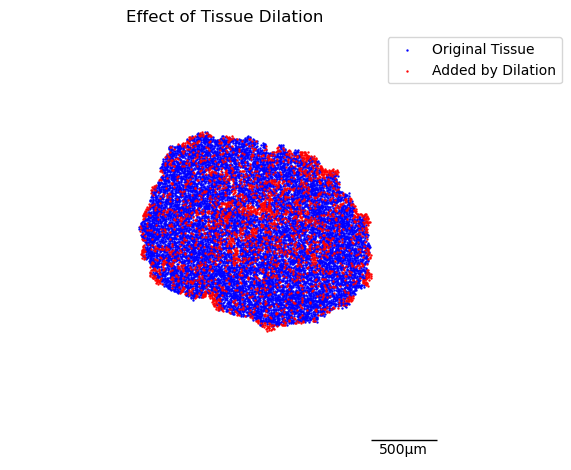

Figure saved as: c85_33_dilated_tissue.png


<Figure size 640x480 with 0 Axes>

In [15]:
plot_tissue(C85_33_adata, fig_title="c85_33_dilated_tissue")

## Plotting Cells

In [16]:
def plot_cell_types(adata_file, specific_types=None, color_dict=None, point_size=4.5, bg_size=4.5, bg_alpha=0.5, fig_title=None):

    # Filter tissue cells
    tissue_mask = adata_file.obs["Tissue"] == "True"
    tissue_data = adata_file.obs[tissue_mask]
    coords = tissue_data[["x", "y"]].values
    cell_types = tissue_data["first_cell_type"]

    # Determine cell types to plot
    if specific_types is None:
        specific_types = cell_types.unique().tolist()
    else:
        missing_types = set(specific_types) - set(cell_types.unique())

    fig, ax = plt.subplots()

    # Plot background beads
    ax.scatter(
        coords[:, 0],
        coords[:, 1],
        s=bg_size,
        color="lightgray",
        alpha=bg_alpha,
        label="Tissue",
    )

    # Plot each cell type
    for cell_type in specific_types:
        type_mask = cell_types == cell_type
        if not type_mask.any():
            continue

        type_coords = coords[type_mask]

        ax.scatter(
            type_coords[:, 0],
            type_coords[:, 1],
            s=point_size,
            color=color_dict[cell_type],
            label=f"{cell_type} (n={type_mask.sum()})",
        )

        print(f"Plotted {type_mask.sum()} cells of type {cell_type}")

    ax.set_aspect("equal", adjustable="box")
    ax.axis("off")
    ax.set_title(fig_title)
    add_scale_bar(ax)

    ax.legend(loc="upper right", bbox_to_anchor=(1.8, 1), borderaxespad=0.0, markerscale=6)
    plt.tight_layout()


    if fig_title and isinstance(fig_title, str) and fig_title.strip():
        save_figure(fig_title)

    plt.show()
    return fig, ax   

Plotted 3789 cells of type PC
Plotted 2159 cells of type GCBC
Plotted 560 cells of type NBC
Plotted 334 cells of type MBC
Figure saved as: b_cells_in_tissue.png


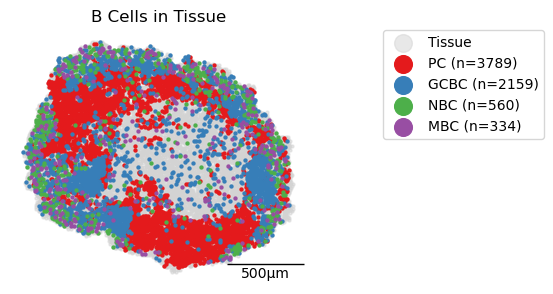

Plotted 3789 cells of type PC
Plotted 2159 cells of type GCBC
Plotted 560 cells of type NBC
Plotted 334 cells of type MBC
Plotted 1670 cells of type Cytotoxic
Plotted 212 cells of type Epithelial
Plotted 1018 cells of type CD4
Plotted 1082 cells of type myeloid
Plotted 1183 cells of type FDC
Plotted 104 cells of type Tfr
Plotted 107 cells of type Tfh
Plotted 67 cells of type PDC
Figure saved as: all_cell_types_in_tissue.png


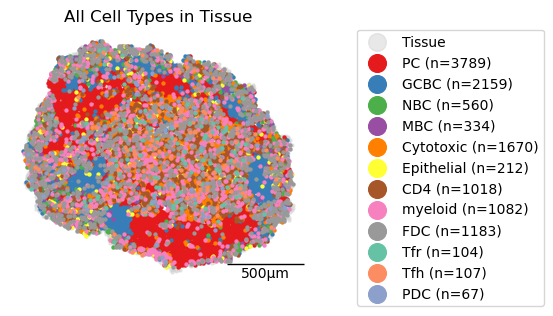

In [17]:
cell_type_colors = {
    "PC": "#e41a1c", 
    "GCBC": "#377eb8",  # Blue
    "NBC": "#4daf4a",  # Green
    "MBC": "#984ea3",  # Purple
    "Cytotoxic": "#ff7f00",  # Orange
    "Epithelial": "#ffff33",  # Yellow
    "CD4": "#a65628",  # Brown
    "myeloid": "#f781bf",  # Pink
    "FDC": "#999999",  # Gray
    "Tfr": "#66c2a5",  # Mint
    "Tfh": "#fc8d62",  # Salmon
    "PDC": "#8da0cb",  # Light blue
}

fig1, ax1 = plot_cell_types(
    C85_33_adata,
    specific_types=["PC", "GCBC", "NBC", "MBC"],
    color_dict=cell_type_colors,
    fig_title="B Cells in Tissue"
)

fig2, ax2 = plot_cell_types(
    C85_33_adata,
    specific_types=[
        "PC",
        "GCBC",
        "NBC",
        "MBC",
        "Cytotoxic",
        "Epithelial",
        "CD4",
        "myeloid",
        "FDC",
        "Tfr",
        "Tfh",
        "PDC",
    ],
    color_dict=cell_type_colors,
    fig_title="All Cell Types in Tissue"
)

## GC Filtering

In [18]:
def create_gc_mask(adata_file):
    # GC Marker Genes
    GCgenes = ["Bcl6", "Aicda", "Rgs13", "Stmn1"]
    X = adata_file[:, GCgenes].X
    if issparse(X):
        X = X.toarray()
    GCgene_mask = np.any(X != 0, axis=1)

    # GCBC singlets
    singlet_mask = adata_file.obs["spot_class"] == "singlet"
    first_type_mask = adata_file.obs["first_cell_type"] == "GCBC"
    GCBC_singlet_mask = singlet_mask & first_type_mask

    # Doublet_certains that are GCBCs
    doublet_mask = adata_file.obs["spot_class"] == "doublet_certain"
    doublet_first = adata_file.obs["first_cell_type"] == "GCBC"
    doublet_second = adata_file.obs["second_cell_type"] == "GCBC"
    GCBC_doublet_mask = doublet_mask & (doublet_first | doublet_second)

    # Combine all masks
    adata_file.obs["GC"] = (GCgene_mask | GCBC_singlet_mask | GCBC_doublet_mask).astype(str)

In [19]:
create_gc_mask(C85_33_adata)

In [20]:
def dbscan_gc_filtering(adata_file, eps=45, min_samples=10):
    # Get coordinates from cells that are labeled as GC
    gc_mask = adata_file.obs["GC"] == "True"
    x_all = np.array(adata_file.obs.loc[gc_mask, "x"])
    y_all = np.array(adata_file.obs.loc[gc_mask, "y"])
    points = np.column_stack((x_all, y_all))

    # Run DBSCAN on the GC-labeled points only
    db = cluster.DBSCAN(eps=eps, min_samples=min_samples)
    clusters = db.fit_predict(points)

    # Get coordinates that pass both GC labeling and DBSCAN clustering
    clean_mask = clusters != -1
    x_clean = x_all[clean_mask]
    y_clean = y_all[clean_mask]
    clean_coords = set(zip(x_clean, y_clean))

    coords_mask = np.array(
        [(x, y) in clean_coords for x, y in zip(adata_file.obs["x"], adata_file.obs["y"])]
    )

    combined_mask = coords_mask & gc_mask
    adata_file.obs["GC_original"] = adata_file.obs["GC"]
    adata_file.obs["GC"] = combined_mask.astype(str)

In [21]:
dbscan_gc_filtering(C85_33_adata)

In [22]:
def dilate_gcs(adata_file, max_itr=10, proportion=0.5):
    if "indices" not in adata_file.obs.columns:
        adata_file.obs["indices"] = list(range(len(adata.obs)))
    # knn

    def knn(adata_file, n_neighbors):
        x = adata_file.obs.x.to_numpy()
        y = adata_file.obs.y.to_numpy()
        bcs = adata_file.obs.index.to_numpy()
        xy = np.array([[x[i], y[i]] for i in range(len(x))])
        nbrs = NearestNeighbors(n_neighbors=n_neighbors + 1, algorithm="ball_tree").fit(
            xy
        )
        distances, indices = nbrs.kneighbors(xy)

        return distances, indices

    def findEnclosed(adata_file, gc_indices):
        gc_indices = set(gc_indices)
        new_indices = set(gc_indices)
        dist, ind = knn(adata_file, 30)

        for i, list_i in enumerate(ind):
            if i in gc_indices:
                continue
            list_i = [x for x, y in zip(list_i, dist[i]) if y <= 50]

            if len([x for x in list_i[1:] if x in gc_indices]) >= proportion * len(
                list_i
            ):
                new_indices.add(i)
        return new_indices

    gc_indices = adata_file.obs[adata_file.obs.GC == "True"].indices.tolist()
    old_indices = gc_indices.copy()
    new_indices = findEnclosed(adata_file, gc_indices)
    # max_itr = 10
    tracker = 0
    while len(new_indices) != len(old_indices) and tracker <= max_itr:
        old_indices = new_indices.copy()
        new_indices = findEnclosed(adata_file, old_indices)
        tracker += 1
    print(f"went through {tracker} iterations")

    adata_file.obs["GC_original"] = adata_file.obs["GC"]

    return new_indices

In [23]:
# Run the dilation function
dilated_indices = dilate_gcs(C85_33_adata, max_itr=15, proportion=0.5)

# Get the index labels corresponding to the numeric indices
index_labels = C85_33_adata.obs.iloc[list(dilated_indices)].index

# Set all these cells to 'True'
C85_33_adata.obs.loc[index_labels, "GC"] = "True"

went through 11 iterations


In [24]:
def plot_dilated_gcs(adata_file):
    # Print statistics to show the effect of dilation
    original_GC_count = (adata_file.obs["GC_original"] == "True").sum()
    dilated_GC_count = (adata_file.obs["GC"] == "True").sum()
    added_cells = dilated_GC_count - original_GC_count

    print(f"Original GC cell #: {original_GC_count}")
    print(f"GC cells # after dilation: {dilated_GC_count}")
    print(f"Added cells: {added_cells} ({100 * added_cells / original_GC_count:.2f}% increase)")


    fig, ax = plt.subplots()

    # Plot Tissue
    ax.scatter(
        x=adata_file.obs[adata_file.obs["Tissue"] == "True"]["x"],
        y=adata_file.obs[adata_file.obs["Tissue"] == "True"]["y"],
        s=0.5,
        color="lightgray",
        label="Tissue",
    )

    # Plot original GC cells
    ax.scatter(
        x=adata_file.obs[adata_file.obs["GC_original"] == "True"]["x"],
        y=adata_file.obs[adata_file.obs["GC_original"] == "True"]["y"],
        s=0.5,
        color="blue",
        label="Original GC",
    )

    # Plot newly added cells from dilation
    mask_added = (adata_file.obs["GC"] == "True") & (adata_file.obs["GC_original"] == "False")
    ax.scatter(
        x=adata_file.obs[mask_added]["x"],
        y=adata_file.obs[mask_added]["y"],
        s=0.5,
        color="red",
        label="Added by Dilation",
    )

    add_scale_bar(ax)

    plt.axis("off")
    ax.set_title("Effect of GC Dilation")
    ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1))
    ax.set_aspect("equal")
    plt.xlim([0, 5000])
    plt.ylim([0, 5000])

    plt.tight_layout()
    plt.show()

Original GC cell #: 1122
GC cells # after dilation: 1578
Added cells: 456 (40.64% increase)


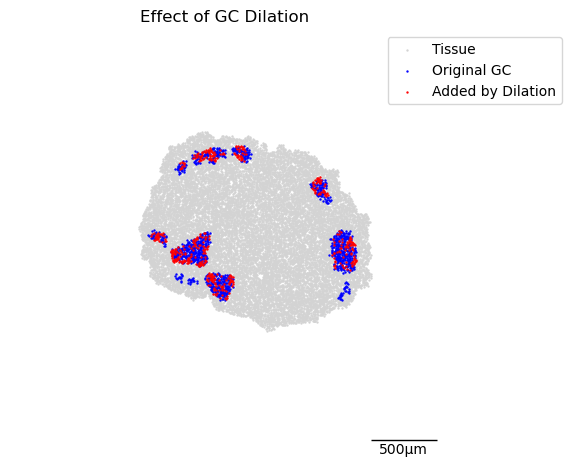

In [25]:
plot_dilated_gcs(C85_33_adata)

In [26]:
def plot_gcs(adata_file): 
    fig, ax = plt.subplots()

    ax.scatter(
        x=adata_file.obs[adata_file.obs["Tissue"] == "True"]["x"],
        y=adata_file.obs[adata_file.obs["Tissue"] == "True"]["y"],
        s=0.5,
        color="lightgray",
        label="Tissue",
    )

    # Plot original GC cells
    ax.scatter(
        x=adata_file.obs[adata_file.obs["GC"] == "True"]["x"],
        y=adata_file.obs[adata_file.obs["GC"] == "True"]["y"],
        s=0.5,
        color="black",
        label="Germinal Centers",
    )

    ax.set_xlim([0, 5000])
    ax.set_ylim([0, 5000])
    ax.axis("off")

    add_scale_bar(ax)

    # Make axes equal and square
    ax.set_aspect("equal", adjustable="box")
    ax.axis("off")
    ax.set_title("Germinal Centers")
    ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1), markerscale=6)
    plt.tight_layout()
    plt.show()

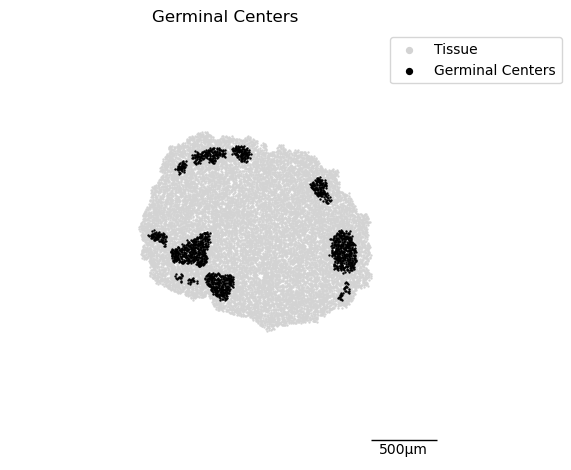

In [27]:
plot_gcs(C85_33_adata)

## PC Calling

In [28]:
def create_pc_mask(adata_file):
    # PC singlets
    singlet_mask = adata_file.obs["spot_class"] == "singlet"
    first_type_pc_mask = adata_file.obs["first_cell_type"] == "PC"
    PC_singlet_mask = singlet_mask & first_type_pc_mask

    # Doublet_certains that are PCs
    doublet_mask = adata_file.obs["spot_class"] == "doublet_certain"
    doublet_first_pc = adata_file.obs["first_cell_type"] == "PC"
    doublet_second_pc = adata_file.obs["second_cell_type"] == "PC"
    PC_doublet_mask = doublet_mask & (doublet_first_pc | doublet_second_pc)

    # Combine singlet and doublet masks for the filtered dataset
    pc_classification_mask = PC_singlet_mask | PC_doublet_mask

    # Get coordinates from cells classified as PCs
    pc_coords = set(
        zip(
            adata_file.obs.loc[pc_classification_mask, "x"],
            adata_file.obs.loc[pc_classification_mask, "y"],
        )
    )

    # First, initialize all cells as 'False' in the main dataset
    adata_file.obs["PC"] = "False"

    # PC is True if it is a PC and in the Tissue
    for idx, row in adata_file.obs.iterrows():
        if (row["x"], row["y"]) in pc_coords and row["Tissue"] == "True":
            adata_file.obs.at[idx, "PC"] = "True"

    pc_count = (adata_file.obs["PC"] == "True").sum()
    tissue_count = (adata_file.obs["Tissue"] == "True").sum()
    print(f"Identified {pc_count} plasma cells in tissue.")
    
    
    # Create masks
    pc_mask = adata_file.obs["PC"] == "True"
    gc_mask = adata_file.obs["GC"] == "True"

    conditions = [
        pc_mask & gc_mask,  # True when PC is True and GC is True
        pc_mask & ~gc_mask,  # False when PC is True and GC is False
    ]

    choices = ["True", "False"]
    adata_file.obs["PCGC"] = np.select(conditions, choices, default="NA")

    # Print statistics
    total_cells = len(adata_file.obs)
    pc_cells = pc_mask.sum()
    gc_cells = gc_mask.sum()
    pcgc_true = (adata_file.obs["PCGC"] == "True").sum()
    pcgc_false = (adata_file.obs["PCGC"] == "False").sum()
    pcgc_na = (adata_file.obs["PCGC"] == "NA").sum()

    print(
        f"PCGC == 'True' (PC and GC True): {pcgc_true} ({100 * pcgc_true / total_cells:.2f}%)"
    )
    print(
        f"PCGC == 'False' (PC True, GC False): {pcgc_false} ({100 * pcgc_false / total_cells:.2f}%)"
    )
    print(f"PCGC == 'NA' (all other cases): {pcgc_na} ({100 * pcgc_na / total_cells:.2f}%)")

    # Label GCBCs that are not Plasma cells

    # GCBC singlets
    singlet_mask = adata_file.obs["spot_class"] == "singlet"
    gcbc_first_type = adata_file.obs.first_cell_type == "GCBC"
    gcbc_singlets = singlet_mask & gcbc_first_type

    # GCBC doublets
    doublet_mask = adata_file.obs["spot_class"] == "doublet_certain"
    gcbc_doublet_first_type = adata_file.obs.first_cell_type == "GCBC"
    gcbc_doublet_second_type = adata_file.obs.second_cell_type == "GCBC"
    gcbc_doublets = doublet_mask & (gcbc_doublet_first_type & gcbc_doublet_second_type)

    gcbc_mask = gcbc_singlets | gcbc_doublets
    gcbc_not_pc = gcbc_mask & (adata_file.obs["PC"] == "False")

    # Store result
    adata_file.obs["GCBC_not_PC"] = gcbc_not_pc.astype(str)
    # Print stats
    gcbc_only_count = (adata_file.obs["GCBC_not_PC"] == "True").sum()
    print(f"Identified {gcbc_only_count} GCBCs that are not plasma cells.")

In [29]:
create_pc_mask(C85_33_adata)

Identified 3409 plasma cells in tissue.
PCGC == 'True' (PC and GC True): 110 (0.44%)
PCGC == 'False' (PC True, GC False): 3299 (13.09%)
PCGC == 'NA' (all other cases): 21800 (86.48%)
Identified 1358 GCBCs that are not plasma cells.


In [30]:
def plot_pcs_in_gcs(adata_file):
    fix, ax = plt.subplots()

    ax.scatter(
        x=adata_file.obs[adata_file.obs["Tissue"] == "True"]["x"],
        y=adata_file.obs[adata_file.obs["Tissue"] == "True"]["y"],
        s=1,
        color="lightgray",
        label="Tissue",
    )

    # Plot original GC cells
    ax.scatter(
        x=adata_file.obs[adata_file.obs["GC"] == "True"]["x"],
        y=adata_file.obs[adata_file.obs["GC"] == "True"]["y"],
        s=1,
        color="black",
        label="Germinal Centers",
    )

    # Plot PCs
    ax.scatter(
        x=adata_file.obs[adata_file.obs["PC"] == "True"]["x"],
        y=adata_file.obs[adata_file.obs["PC"] == "True"]["y"],
        s=1,
        color="red",
        label="Plasma Cells",
    )

    # Add scalebar
    ax.set_xlim([0, 5000])
    ax.set_ylim([0, 5000])
    # plt.axis('off')

    add_scale_bar(ax)


    # Make axes equal and square
    ax.set_aspect("equal", adjustable="box")
    ax.axis("off")
    ax.set_title("Plasma Cells in Germinal Center ")
    ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1), markerscale=6)
    plt.tight_layout()
    plt.show()

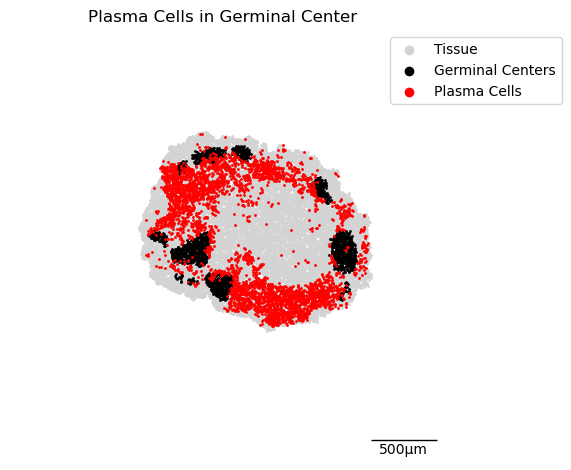

In [31]:
plot_pcs_in_gcs(C85_33_adata)

In [32]:
def plot_all_pcs(adata_file):
    fig, ax = plt.subplots()

    ax.scatter(
        x=adata_file.obs[adata_file.obs["Tissue"] == "True"]["x"],
        y=adata_file.obs[adata_file.obs["Tissue"] == "True"]["y"],
        s=0.5,
        color="lightgray",
        label="Tissue",
    )


    # Plot PCs
    ax.scatter(
        x=adata_file.obs[adata_file.obs["PC"] == "True"]["x"],
        y=adata_file.obs[adata_file.obs["PC"] == "True"]["y"],
        s=0.5,
        color="red",
        label="Plasma Cells",
    )



    # Add scalebar
    ax.set_xlim([0, 5000])
    ax.set_ylim([0, 5000])
    # plt.axis('off')

    add_scale_bar(ax)


    # Make axes equal and square
    ax.set_aspect("equal", adjustable="box")

    ax.axis("off")
    ax.set_title("Plasma Cells in Tissue")
    ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1), markerscale=6)
    plt.tight_layout()
    plt.show()

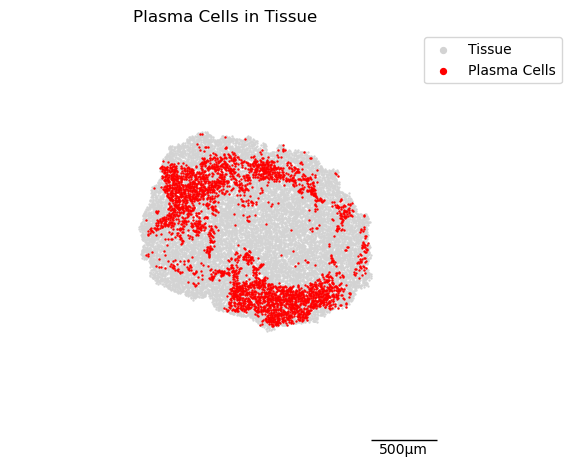

In [33]:
plot_all_pcs(C85_33_adata)

In [34]:
def plot_pc_gc_distribution(adata_file, fig_title=None):
    tissue_mask = adata_file.obs["Tissue"] == "True"
    pc_mask = adata_file.obs["PC"] == "True"
    gc_mask = adata_file.obs["GC"] == "True"

    # PC in GC (PCGC)
    pcgc_mask = pc_mask & gc_mask

    # PC outside GC
    pc_only_mask = pc_mask & ~gc_mask

    # GC tissue
    # gc_only_mask = gc_mask & ~pc_mask
    gc_only_mask = gc_mask

    
    fig, ax = plt.subplots()
    
    # Plot tissue
    ax.scatter(
        x=adata_file.obs[tissue_mask]["x"],
        y=adata_file.obs[tissue_mask]["y"],
        s=4.5,
        color="lightgray",
        label="Tissue",
        alpha=0.5,
    )
   


    ax.scatter(
        x=adata_file.obs[gc_only_mask]["x"],
        y=adata_file.obs[gc_only_mask]["y"],
        s=4.5,
        color="#0072B2",
        # label=f"GCs (n={np.sum(gc_only_mask)})",
        label=f"GCs",
    )

    # Plot PC cells (excluding PCGCs)
    ax.scatter(
        x=adata_file.obs[pc_only_mask]["x"],
        y=adata_file.obs[pc_only_mask]["y"],
        s=4.5,
        color="#D55E00",
        label=f"PC outside GC (n={np.sum(pc_only_mask)})",
    )

    # Plot PCGC cells
    ax.scatter(
        x=adata_file.obs[pcgc_mask]["x"],
        y=adata_file.obs[pcgc_mask]["y"],
        s=4.5,
        color="Black",
        label=f"PC in GC (n={np.sum(pcgc_mask)})",
    )
    add_scale_bar(ax)
    ax.set_aspect("equal")
    plt.axis("off")

    ax.set_title("Plasma Cells in Germinal Centers")
    ax.legend(loc="upper right", bbox_to_anchor=(1.8, 1), markerscale=6)
    plt.tight_layout()

    # Print statistics
    total_pc = np.sum(pc_mask)
    total_gc = np.sum(gc_mask)
    total_pcgc = np.sum(pcgc_mask)

    print(f"Total Plasma Cells: {total_pc}")
    print(f"Total Germinal Center cells: {total_gc}")
    print(
        f"Plasma Cells in Germinal Centers: "
        f"{total_pcgc} ({total_pcgc/total_pc*100:.1f}% of all PCs)"
    )
    print(f"Percentage of GC cells that are PCs: {total_pcgc/total_gc*100:.1f}%")
    if fig_title and isinstance(fig_title, str) and fig_title.strip():
        save_figure(fig_title)
    plt.show()

    plt.savefig("pcingc.png")

Total Plasma Cells: 3409
Total Germinal Center cells: 1578
Plasma Cells in Germinal Centers: 110 (3.2% of all PCs)
Percentage of GC cells that are PCs: 7.0%
Figure saved as: plasma_cells_in_germinal_centers.png


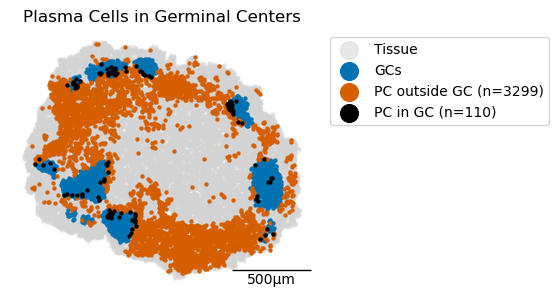

<Figure size 640x480 with 0 Axes>

In [35]:
plot_pc_gc_distribution(C85_33_adata, fig_title="Plasma Cells in Germinal Centers")

In [36]:
# Process for cside
import json

pcgc_barcodes = C85_33_adata.obs_names[C85_33_adata.obs["PCGC"] == "True"]
pc_not_gc_barcodes = C85_33_adata.obs_names[C85_33_adata.obs["PCGC"] == "False"]

# Dict for CSIDE
barcode_dict = {
    "pc_in_gc": pcgc_barcodes.tolist(),
    "pc_no_gc": pc_not_gc_barcodes.tolist(),
}

# Save to JSON file
with open("barcode_groups.json", "w") as f:
    json.dump(barcode_dict, f)

In [37]:
Counter(C85_33_adata.obs.PCGC)

Counter({'False': 3299, 'NA': 21800, 'True': 110})

In [38]:
pc_all_genes = pd.read_csv("PC_all_genes_c85_33.csv")
pc_all_genes.set_index(pc_all_genes.columns[0], inplace=True)
pc_all_genes.columns = pc_all_genes.columns.str.replace("Gene.", "", regex=False)
pc_all_genes.index.name = "Gene"
pc_all_genes["neg_log10_pval"] = -np.log10(pc_all_genes.p_val)

Figure saved as: c85_33_violin_plot.png


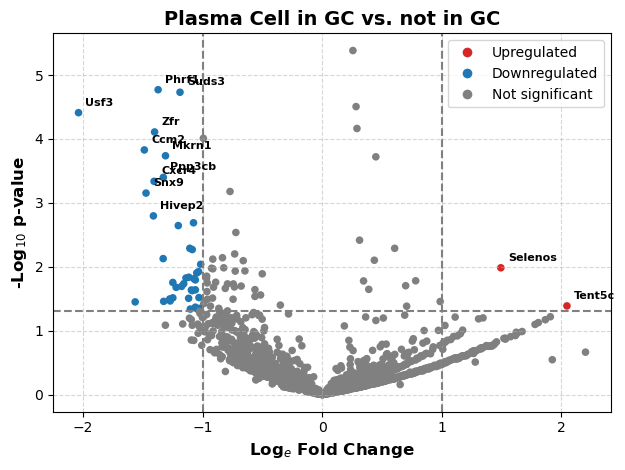

In [39]:
def volcano_plot(pc_all_genes, fig_title="c85_33_violin_plot"):

    fig, ax = plt.subplots()

    # Significance thresholds
    log_fc_threshold = 1.0
    p_val_threshold = 0.05
    neg_log10_pval_threshold = -np.log10(p_val_threshold)

    # Create colors based on significance and direction
    pc_all_genes["color"] = "gray"
    mask_up = (pc_all_genes["log_fc"] >= log_fc_threshold) & (
        pc_all_genes["p_val"] < p_val_threshold
    )
    mask_down = (pc_all_genes["log_fc"] <= -log_fc_threshold) & (
        pc_all_genes["p_val"] < p_val_threshold
    )
    pc_all_genes.loc[mask_up, "color"] = "tab:red"  # Upregulated
    pc_all_genes.loc[mask_down, "color"] = "tab:blue"  # Downregulated

    # Create the scatter plot
    ax.scatter(
        x=pc_all_genes.log_fc,
        y=pc_all_genes.neg_log10_pval,
        c=pc_all_genes["color"],
        s=30,
        edgecolor="none",
    )

    # Add threshold lines
    ax.axhline(y=neg_log10_pval_threshold, color="gray", linestyle="--", alpha=1)
    ax.axvline(x=log_fc_threshold, color="gray", linestyle="--", alpha=1)
    ax.axvline(x=-log_fc_threshold, color="gray", linestyle="--", alpha=1)

    # Set plot labels
    ax.set_xlabel("Log$_e$ Fold Change", fontsize=12, fontweight="bold")
    ax.set_ylabel("-Log$_{10}$ p-value", fontsize=12, fontweight="bold")
    ax.set_title("Plasma Cell in GC vs. not in GC", fontsize=14, fontweight="bold")
    ax.grid(True, linestyle="--", alpha=0.5)

    # Select only significant genes that meet fold change thresholds
    sig_genes = pc_all_genes[
        (pc_all_genes["neg_log10_pval"] > neg_log10_pval_threshold)
        & (abs(pc_all_genes["log_fc"]) > log_fc_threshold)
    ]

    # Get top 5 upregulated genes (by significance)
    up_genes = sig_genes[sig_genes["log_fc"] > log_fc_threshold].nlargest(
        5, "neg_log10_pval"
    )

    # Get top 5 downregulated genes (by significance)
    down_genes = sig_genes[sig_genes["log_fc"] < -log_fc_threshold].nlargest(
        10, "neg_log10_pval"
    )

    # Combine genes to annotate
    genes_to_annotate = pd.concat([up_genes, down_genes])

    # Annotate selected genes
    for i, gene in genes_to_annotate.iterrows():
        ax.annotate(
            i,  # Using index as gene name
            xy=(gene["log_fc"], gene["neg_log10_pval"]),
            xytext=(5, 5),
            textcoords="offset points",
            fontsize=8,
            color="black",
            fontweight="bold",
        )

    legend_elements = [
        Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            markerfacecolor="tab:red",
            markersize=8,
            label="Upregulated",
        ),
        Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            markerfacecolor="tab:blue",
            markersize=8,
            label="Downregulated",
        ),
        Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            markerfacecolor="gray",
            markersize=8,
            label="Not significant",
        ),
    ]
    ax.legend(handles=legend_elements, loc="best", frameon=True)

    if fig_title and isinstance(fig_title, str) and fig_title.strip():
        save_figure(fig_title)
            
    plt.tight_layout()
    plt.show()
           
volcano_plot(pc_all_genes, fig_title="c85_33_violin_plot")

## Violin Plots

In [40]:
proliferation_set = ["Mki67", "Cdk1", "Top2a", "Pcna"]

In [41]:
fig_7f_genes = ["Jchain", "Ighg1", "Igkc", "Calr", "Pdia4", "Hspa5"]

In [42]:
fig_s8H_genes  = [ "Ighg2b", "Ighg2c", "Xbp1", "Ell2"]

### Gene Set

In [43]:
def compare_gene_sets_expression_mwu(
    adata,
    geneset,
    gcbc_col="GCBC_not_PC",
    pcgc_col="PCGC",
    normalize=True,
    log_transform=True,
    violin_kwargs=None,
    n_cols=3,
    fig_width=5,
    fig_height=5.5,
    fontsize=18,
    output_file="gene_set_violin_plots.png",
    show_points=True,
    point_kwargs=None,
    run_stats=True,
    use_raw=False,
    fig_title=None,
    gene_set_name=None
):

    if show_points:
        violin_kwargs = violin_kwargs or {
            "inner": None,
            "palette": "viridis",
            "alpha": 1,
        }
    else:
        violin_kwargs = violin_kwargs or {
            "inner": "quartile",
            "palette": "viridis",
            "alpha": 0.8,
            "linewidth": 1.5,
        }

    point_kwargs = point_kwargs or {"size": 2, "alpha": 0.6, "color": "black"}
    plt.rcParams.update({"font.size": fontsize, "axes.titlesize": fontsize + 2})

    # Handle single gene list input
    geneset = prepare_geneset_dict(geneset)

    # Assign cell types
    cell_types = assign_cell_types_vectorized(adata, gcbc_col, pcgc_col)
    adata.obs["cell_type"] = cell_types

    # Calculate gene set scores using scanpy
    valid_genesets = {}
    all_missing_genes = []

    for name, genes in geneset.items():
        valid_genes = [g for g in genes if g in adata.var_names]
        missing_genes = [g for g in genes if g not in adata.var_names]

        if valid_genes:
            # Use scanpy to calculate gene set scores
            sc.tl.score_genes(
                adata,
                gene_list=valid_genes,
                score_name=f"{name}_score",
                use_raw=use_raw,
            )
            valid_genesets[name] = valid_genes

        if missing_genes:
            all_missing_genes.extend([(name, gene) for gene in missing_genes])
            print(
                f"Warning: {len(missing_genes)} genes not found in {name}: {missing_genes}"
            )
        #calculate normalized summed expression of genes in gene set
        X = adata[:, valid_genes].X
        if scipy.sparse.issparse(X):
                    X = X.toarray()

        total_umi = np.array(adata.X.sum(axis=1)).flatten()
        total_umi[total_umi == 0] = 1
        X_norm = (X / total_umi[:, None]) * 10000
        X_norm = np.log1p(X_norm)

        summed_expr = X_norm.sum(axis=1)

        # Save into adata.obs so you can access it later
        adata.obs[f"{name}_summed_expr"] = summed_expr

        # Print cell-type means for sanity check
        print(f"\n{name} (summed normalized expression):")
        for ct in ["GCBC", "PC in GC", "PC ex GC"]:
            mask = adata.obs["cell_type"] == ct
            if mask.sum() > 0:
                print(f"  {ct}: mean = {summed_expr[mask].mean():.3f}")

        valid_genesets[name] = valid_genes
    

    if not valid_genesets:
        print("Warning: No valid gene sets found")
        return None

    # Filter to only the three cell types of interest
    cell_types_of_interest = ["GCBC", "PC in GC", "PC ex GC"]
    adata_subset = adata[adata.obs["cell_type"].isin(cell_types_of_interest)].copy()

    # Create dataframe for plotting
    score_columns = [
        f"{n}_score"
        for n in valid_genesets.keys()
        if f"{n}_score" in adata_subset.obs.columns
    ]
    df = adata_subset.obs[["cell_type"] + score_columns].copy()

    df = df.melt(
        id_vars="cell_type",
        value_vars=score_columns,
        var_name="Gene Set",
        value_name="Module Score",
    )

    # Remove "_score" suffix from gene set names
    df["Gene Set"] = df["Gene Set"].str.replace("_score", "", regex=False)

    # Setup plot grid
    set_names = list(valid_genesets.keys())
    n_rows = math.ceil(len(set_names) / n_cols)
    fig, axes = plt.subplots(
        n_rows, n_cols, figsize=(fig_width * n_cols, fig_height * n_rows)
    )
    axes = np.array([axes]).flatten() if len(set_names) == 1 else axes.flatten()

    # Create plots with statistical analysis
    results_df, stats_results = create_scanpy_geneset_violin_plots_grid(
        axes,
        df,
        set_names,
        cell_types_of_interest,
        violin_kwargs,
        n_cols,
        fontsize,
        show_points,
        point_kwargs,
        run_stats,
        gene_set_name=gene_set_name
    )

    # Hide unused axes
    for i in range(len(set_names), len(axes)):
        axes[i].set_visible(False)

    plt.tight_layout()
    plt.savefig(output_file, dpi=300, bbox_inches="tight", facecolor="white")
    plt.show()

    # Print statistical results
    if run_stats and stats_results:
        print("\n")
        print("Gene set results: ")
        print_statistical_results(stats_results)

    if fig_title and isinstance(fig_title, str) and fig_title.strip():
        save_figure(fig_title)
        
    return results_df


def create_scanpy_geneset_violin_plots_grid(
    axes,
    df,
    set_names,
    cell_types_of_interest,
    violin_kwargs,
    n_cols,
    fontsize,
    show_points=True,
    point_kwargs=None,
    run_stats=True,
    gene_set_name=None
):
    all_results = []
    stats_results = []

    # Default point settings
    if point_kwargs is None:
        point_kwargs = {"size": 2, "alpha": 0.6, "color": "black"}

    for i, set_name in enumerate(set_names):
        # Filter data for this gene set
        df_set = df[df["Gene Set"] == set_name].copy()
        df_set = df_set.rename(
            columns={"cell_type": "Cell Type", "Module Score": "Expression"}
        )

        # Add to results
        plot_data = df_set.to_dict("records")
        all_results.extend(plot_data)

        # Run statistical tests if requested
        if run_stats:
            geneset_stats = perform_geneset_statistical_tests(df_set, set_name)
            stats_results.append(geneset_stats)

        # Create violin plot
        sns.violinplot(
            data=df_set,
            x="Cell Type",
            y="Expression",
            order=cell_types_of_interest,
            ax=axes[i],
            **violin_kwargs,
        )

        # Add points if requested
        if show_points:
            sns.stripplot(
                data=df_set,
                x="Cell Type",
                y="Expression",
                order=cell_types_of_interest,
                ax=axes[i],
                jitter=0.3,
                dodge=True,
                **point_kwargs,
            )

        # Add significance annotations if stats were run
        if run_stats and geneset_stats:
            add_geneset_significance_annotations(
                axes[i], geneset_stats, df_set, cell_types_of_interest
            )

        axes[i].set_title(gene_set_name, fontsize=fontsize + 2, fontweight="bold")
        axes[i].set_ylabel("Gene Set Enrichment Score" if i % n_cols == 0 else "")
        axes[i].set_xlabel("")
        axes[i].tick_params(axis="x", rotation=45)

    return pd.DataFrame(all_results), stats_results


def assign_cell_types_vectorized(adata, gcbc_col, pcgc_col):
    """
    Assign cell types based on gcbc_col and pcgc_col
    """
    obs = adata.obs
    cell_types = pd.Series("Other", index=obs.index)
    cell_types.loc[obs[gcbc_col] == "True"] = "GCBC"
    cell_types.loc[obs[pcgc_col] == "True"] = "PC in GC"
    cell_types.loc[obs[pcgc_col] == "False"] = "PC ex GC"
    return cell_types.values


def prepare_geneset_dict(geneset):
    """
    Ensure gene set is a dictionary
    """
    if isinstance(geneset, list):
        return {"Gene_Set": geneset}
    return geneset

def perform_geneset_statistical_tests(df_set, set_name, alpha=0.05):
    """
    Perform pairwise Mann–Whitney U tests across the 3 groups
    with Holm correction for multiple testing.
    """
    ordered = ["GCBC","PC in GC","PC ex GC"]
    data = {g: df_set.loc[df_set["Cell Type"] == g, "Expression"].values for g in ordered}

    pairs, raw_pvals, adj_pvals, sigs, directions = [], [], [], [], []

    # Perform pairwise Mann–Whitney U tests
    for i in range(len(ordered)):
        for j in range(i+1, len(ordered)):
            g1, g2 = ordered[i], ordered[j]
            u, p = mannwhitneyu(data[g1], data[g2], alternative="two-sided")
            
            # store raw results
            pairs.append((g1, g2))
            raw_pvals.append(p)
            
            # compute directionality by comparing medians
            med1, med2 = np.median(data[g1]), np.median(data[g2])
            if med1 > med2:
                directions.append(f"{g1} > {g2}")
            elif med1 < med2:
                directions.append(f"{g1} < {g2}")
            else:
                directions.append("equal")

    # Multiple testing correction (Holm–Bonferroni)
    reject, pvals_corrected, _, _ = multipletests(raw_pvals, alpha=alpha, method="holm")
    sigs = reject.tolist()
    adj_pvals = pvals_corrected.tolist()

    return {
        "gene": set_name,
        "pairs": pairs,
        "raw_pvals": raw_pvals,
        "adj_pvals": adj_pvals,
        "significant": sigs,
        "directionality": directions
    }

def add_geneset_significance_annotations(ax, stats, df_set, ordered_cell_types):
    y = df_set["Expression"].max()
    rng = df_set["Expression"].max() - df_set["Expression"].min()
    offsets = {
        ("GCBC","PC in GC"): 0.08,
        ("GCBC","PC ex GC"): 0.16,
        ("PC in GC","PC ex GC"): 0.24,
    }
    for (a,b), p_adj, sig in zip(stats["pairs"], stats["adj_pvals"], stats["significant"]):
        x1 = ordered_cell_types.index(a)
        x2 = ordered_cell_types.index(b)
        off = offsets[(a,b)] * rng
        ax.plot([x1,x2],[y+off]*2, "k-", lw=1)
        ax.plot([x1,x1],[y+off, y+off-0.02*rng], "k-", lw=1)
        ax.plot([x2,x2],[y+off, y+off-0.02*rng], "k-", lw=1)
        if sig:
            if p_adj<0.001: star="***"
            elif p_adj<0.01:  star="**"
            else:            star="*"
        else:
            star="ns"
        ax.text((x1+x2)/2, y+off-0.01*rng, star,
                ha="center", va="bottom", fontweight="bold")
        
def print_statistical_results(stats_results):
    """
    Print pairwise Mann–Whitney U test results with Holm-adjusted p-values.
    """
    for gene_stats in stats_results:
        gene = gene_stats["gene"]
        print(f"\n{gene}:")
        print("-" * len(gene))
        
        if not gene_stats["pairs"]:
            print("  No pairwise comparisons")
            continue
        
        directions = gene_stats.get("directionality", [""] * len(gene_stats["pairs"]))
        for i, ((g1, g2), p_adj, sig) in enumerate(zip(
            gene_stats["pairs"],
            gene_stats["adj_pvals"],
            gene_stats["significant"]
        )):
            if p_adj < 0.001:
                star = "***"
            elif p_adj < 0.01:
                star = "**"
            elif p_adj < 0.05:
                star = "*"
            else:
                star = "ns"
            
            dir_str = f" ({directions[i]})" if directions[i] else ""
            
            print(f"  {g1} vs {g2}: Mann–Whitney adj p = {p_adj:.3g} {star}{dir_str}")

/PHShome/rl042/.conda/envs/affinity_brake_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):



Gene_Set (summed normalized expression):
  GCBC: mean = 4.829
  PC in GC: mean = 3.775
  PC ex GC: mean = 2.419


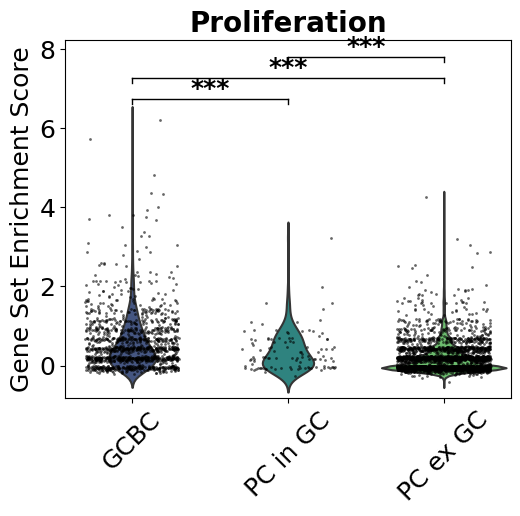



Gene set results: 

Gene_Set:
--------
  GCBC vs PC in GC: Mann–Whitney adj p = 0.000984 *** (GCBC > PC in GC)
  GCBC vs PC ex GC: Mann–Whitney adj p = 9.41e-117 *** (GCBC > PC ex GC)
  PC in GC vs PC ex GC: Mann–Whitney adj p = 2.83e-05 *** (PC in GC > PC ex GC)
Figure saved as: proliferation_vionlin_points.png


<Figure size 640x480 with 0 Axes>

In [44]:
results_df = compare_gene_sets_expression_mwu(
    C85_33_adata, geneset=proliferation_set, show_points=True, gene_set_name="Proliferation", fig_title="proliferation_vionlin_points"
)

### Single Gene

In [45]:
def gene_expression_MWU_violin_plots(
    adata,
    gene_list,
    gcbc_col="GCBC_not_PC",
    pcgc_col="PCGC",
    violin_kwargs=None,
    n_cols=1,
    fig_height=3.5,
    fig_width=3.5,
    fontsize=25,
    show_points=True,
    run_stats=True,
    remove_zeros=False,
    fig_title=None,
    show_sig=True
):

    # Filter valid genes
    valid_genes = [gene for gene in gene_list if gene in adata.var_names]
    if not valid_genes:
        print("Warning: No genes found in dataset")
        return None
    missing_genes = [gene for gene in gene_list if gene not in valid_genes]
    if missing_genes:
        print(
            f"Warning: {len(missing_genes)} genes not found in the dataset: {missing_genes}"
        )

    
    if show_points:
        violin_kwargs = violin_kwargs or {
            "inner": None,
            "palette": "viridis",
            "alpha": 1,
        }
    else:
        violin_kwargs = violin_kwargs or {
            "inner": "quartile",
            "palette": "viridis",
            "alpha": 0.8,
        }

    plt.rcParams.update({"font.size": fontsize, "axes.titlesize": fontsize + 2})

    # Define GCBC, PC in GC, PC not in GC
    cell_types = assign_cell_types_vectorized(adata, gcbc_col, pcgc_col)

    # Normalize expression data
    expression_data = prepare_expression_data(adata, valid_genes)

    # Create subplot grid
    n_rows = math.ceil(len(valid_genes) / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(fig_width * n_cols, fig_height * n_rows))
    axes = np.array([axes]).flatten() if len(valid_genes) == 1 else axes.flatten()

    results_df, stats_results = create_violin_plots_grid(
        axes, valid_genes, expression_data, cell_types, violin_kwargs,
        n_cols, fontsize, show_points, remove_zeros=remove_zeros, show_sig=show_sig
    )

    # Hide blank subplots
    for i in range(len(valid_genes), len(axes)):
        axes[i].set_visible(False)
    
    if fig_title and isinstance(fig_title, str) and fig_title.strip():
        save_figure(fig_title)

    plt.subplots_adjust(hspace=0.25, wspace=0.2)  
    plt.show()

    print("\n")
    print_statistical_results(stats_results)

    return results_df


def assign_cell_types_vectorized(adata, gcbc_col, pcgc_col):
    obs = adata.obs
    cell_types = pd.Series("Other", index=obs.index)
    cell_types.loc[obs[gcbc_col] == "True"] = "GCBC"
    cell_types.loc[obs[pcgc_col] == "True"] = "PC in GC"
    cell_types.loc[obs[pcgc_col] == "False"] = "PC ex GC"
    return cell_types.values


def prepare_expression_data(adata, genes):
    """
    Normalizes gene expression per bead by dividing gene count by total UMI count per bead.
    
    Parameters:
    - adata: AnnData Object
    - genes: list of strings
    """
    
    X = adata[:, genes].X
    if scipy.sparse.issparse(X):
        X = X.toarray()

    # Total UMI count per cell
    total_umi = np.array(adata.X.sum(axis=1)).flatten()
    # Avoid division by zero
    total_umi[total_umi == 0] = 1
    # Normalize each gene by total UMI count per cell
    X = X / total_umi[:, None] *10000

    X = np.log1p(X)
    return X


def create_violin_plots_grid(
    axes,
    genes,
    expression_data,
    cell_types,
    violin_kwargs,
    n_cols,
    fontsize,
    show_points=True, 
    remove_zeros=False,
    show_sig = True
):
    ordered_cell_types = ["GCBC", "PC in GC", "PC ex GC"]
    all_results = []
    stats_results = []

    for i, gene in enumerate(genes):        
        expr_col = expression_data[:, i]
        mask = np.isin(cell_types, ordered_cell_types)
        
        # Print zero expression counts
        total_cells = mask.sum()
        zero_cells = (expr_col[mask] == 0).sum()
        print(f"{gene}: {zero_cells}/{total_cells} cells ({zero_cells/total_cells*100:.1f}%) have 0 expression")
        
        # Print by cell type
        for ct in ordered_cell_types:
            ct_mask = mask & (cell_types == ct)
            ct_total = ct_mask.sum()
            ct_zeros = (expr_col[ct_mask] == 0).sum()
            if ct_total > 0:
                print(f"  {ct}: {ct_zeros}/{ct_total} ({ct_zeros/ct_total*100:.1f}%)")
        
        if remove_zeros:
            mask &= (expr_col > 0)

        plot_data = [
            {"Gene": gene, "Cell Type": ct, "Expression": expr}
            for ct, expr in zip(cell_types[mask], expr_col[mask])
        ]

        df_gene = pd.DataFrame(plot_data)
        all_results.extend(plot_data)

        gene_stats = perform_statistical_tests(df_gene, gene)
        stats_results.append(gene_stats)

        # Create violin plot
        sns.violinplot(
            data=df_gene,
            x="Cell Type",
            y="Expression",
            ax=axes[i],
            order=ordered_cell_types,
            **violin_kwargs,
        )

        if show_points:
            sns.stripplot(
                data=df_gene,
                x="Cell Type",
                y="Expression",
                ax=axes[i],
                order=ordered_cell_types,
                size=2,
                alpha=0.6,
                jitter=True,
                color="black",
            )
        n_plots = len(genes)
        n_rows = int(np.ceil(n_plots / n_cols))
        row = i // n_cols 

        if row == n_rows - 1:
            axes[i].set_xticklabels(
                axes[i].get_xticklabels(),
                rotation=45,
                fontsize=fontsize,
                fontweight='bold'
            )
        else:
            axes[i].set_xlabel("")
            axes[i].set_xticklabels([])
        
        if show_sig:
            add_significance_annotations(axes[i], gene_stats, df_gene, ordered_cell_types)

        axes[i].set_title(gene, fontsize=fontsize + 2, fontweight="bold")
        axes[i].set_xlabel("")
        axes[i].yaxis.label.set_visible(False)
        axes[i].tick_params(axis="x", width=2.5, rotation=45)
        axes[i].tick_params(axis="y", width=2.5, labelsize=30)
        
        for label in axes[i].get_yticklabels():
            label.set_fontweight("bold")
            
        for spine in axes[i].spines.values():
            spine.set_linewidth(2.5)
            
        y_min, y_max = axes[i].get_ylim()
        axes[i].set_ylim(y_min, y_max * 1.025)
    
    return pd.DataFrame(all_results), stats_results

def perform_statistical_tests(df_gene, gene, alpha=0.05):
    """
    Perform pairwise Mann–Whitney U tests with Holm correction.
    """
    ordered = ["GCBC", "PC in GC", "PC ex GC"]
    data = {g: df_gene.loc[df_gene["Cell Type"] == g, "Expression"].values for g in ordered}

    pairs, raw_pvals, adj_pvals, sigs, directions = [], [], [], [], []

    # Pairwise Mann–Whitney U tests
    for i in range(len(ordered)):
        for j in range(i+1, len(ordered)):
            g1, g2 = ordered[i], ordered[j]
            u, p = mannwhitneyu(data[g1], data[g2], alternative="two-sided")
            pairs.append((g1, g2))
            raw_pvals.append(p)

            med1, med2 = np.median(data[g1]), np.median(data[g2])
            if med1 > med2:
                directions.append(f"{g1} > {g2}")
            elif med1 < med2:
                directions.append(f"{g1} < {g2}")
            else:
                directions.append("equal")

    # Holm-Bonferroni correction
    reject, pvals_corrected, _, _ = multipletests(raw_pvals, alpha=alpha, method="holm")
    sigs = reject.tolist()
    adj_pvals = pvals_corrected.tolist()

    return {
        "gene": gene,
        "pairs": pairs,
        "raw_pvals": raw_pvals,
        "adj_pvals": adj_pvals,
        "significant": sigs,
        "directionality": directions
    }

def add_significance_annotations(ax, gene_stats, df_gene, ordered_cell_types):
    """
    Annotates violin plot with significance levels from Mann–Whitney tests.
    """
    y_max = df_gene["Expression"].max()
    y_range = df_gene["Expression"].max() - df_gene["Expression"].min()

    positions = {
        ("GCBC", "PC in GC"): (0, 1, y_max + 0.08 * y_range),
        ("GCBC", "PC ex GC"): (0, 2, y_max + 0.16 * y_range),
        ("PC in GC", "PC ex GC"): (1, 2, y_max + 0.24 * y_range),
    }

    for pair, p_adj, sig in zip(
        gene_stats["pairs"], gene_stats["adj_pvals"], gene_stats["significant"]
    ):
        if pair not in positions:
            continue
        x1, x2, y = positions[pair]

        ax.plot([x1, x2], [y, y], "k-", linewidth=1)
        ax.plot([x1, x1], [y, y - 0.02 * y_range], "k-", linewidth=1)
        ax.plot([x2, x2], [y, y - 0.02 * y_range], "k-", linewidth=1)

        if sig and p_adj < 0.001:
            text = "***"
        elif sig and p_adj < 0.01:
            text = "**"
        elif sig and p_adj < 0.05:
            text = "*"
        else:
            text = "ns"

        y_offset = -0.03 * y_range if text != "ns" else -0.0095 * y_range
        ax.text((x1 + x2) / 2, y + y_offset, text, ha="center", va="bottom", fontweight="bold", fontsize=12)

def print_statistical_results(stats_results):
    for stats in stats_results:
        gene = stats.get("gene", "<unknown>")
        print(f"\n{gene}:")
        print("-" * (len(gene) + 1))
        
        for (grp1, grp2), p_adj, sig, direction in zip(
            stats["pairs"], stats["adj_pvals"], stats["significant"], stats["directionality"]
        ):
            if p_adj < 0.001:
                star = "***"
            elif p_adj < 0.01:
                star = "**"
            elif p_adj < 0.05:
                star = "*"
            else:
                star = "ns"

            print(f"  {grp1} vs {grp2}: Mann–Whitney adj p = {p_adj:.3g} {star}; {direction}")

Jchain: 2667/4767 cells (55.9%) have 0 expression
  GCBC: 1167/1358 (85.9%)
  PC in GC: 56/110 (50.9%)
  PC ex GC: 1444/3299 (43.8%)
Ighg1: 2751/4767 cells (57.7%) have 0 expression
  GCBC: 1116/1358 (82.2%)
  PC in GC: 65/110 (59.1%)
  PC ex GC: 1570/3299 (47.6%)
Igkc: 339/4767 cells (7.1%) have 0 expression
  GCBC: 335/1358 (24.7%)
  PC in GC: 0/110 (0.0%)
  PC ex GC: 4/3299 (0.1%)
Calr: 1849/4767 cells (38.8%) have 0 expression
  GCBC: 966/1358 (71.1%)
  PC in GC: 30/110 (27.3%)
  PC ex GC: 853/3299 (25.9%)
Pdia4: 2071/4767 cells (43.4%) have 0 expression
  GCBC: 1151/1358 (84.8%)
  PC in GC: 37/110 (33.6%)
  PC ex GC: 883/3299 (26.8%)
Hspa5: 956/4767 cells (20.1%) have 0 expression
  GCBC: 769/1358 (56.6%)
  PC in GC: 9/110 (8.2%)
  PC ex GC: 178/3299 (5.4%)
Figure saved as: 7f_violin_plot_no_points.png


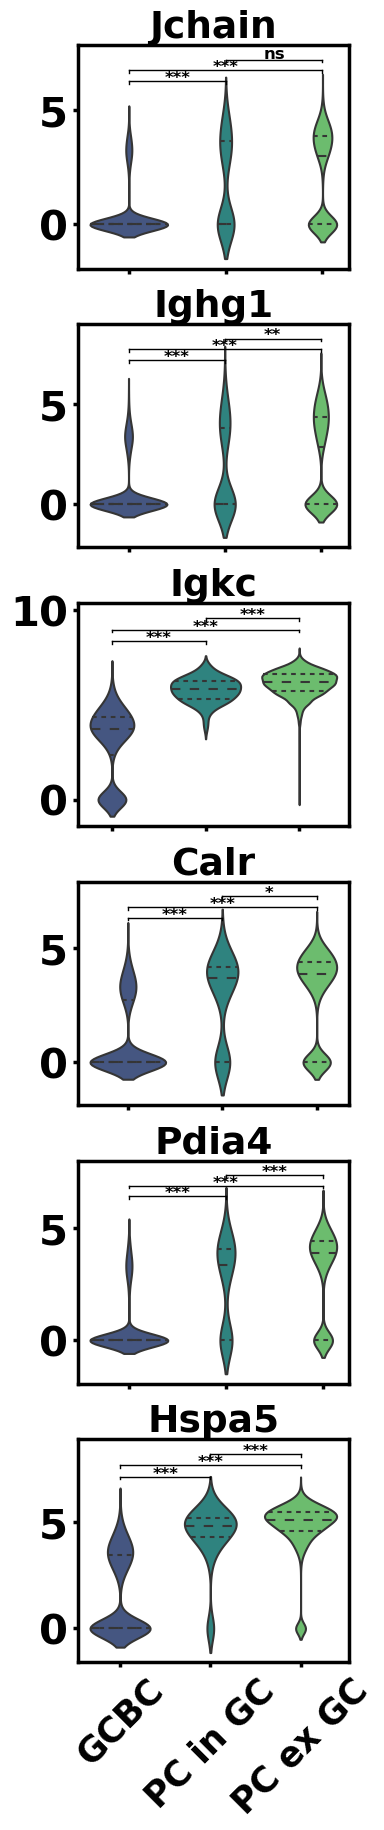




Jchain:
-------
  GCBC vs PC in GC: Mann–Whitney adj p = 1.23e-23 ***; equal
  GCBC vs PC ex GC: Mann–Whitney adj p = 1.39e-161 ***; GCBC < PC ex GC
  PC in GC vs PC ex GC: Mann–Whitney adj p = 0.0886 ns; PC in GC < PC ex GC

Ighg1:
------
  GCBC vs PC in GC: Mann–Whitney adj p = 1.93e-11 ***; equal
  GCBC vs PC ex GC: Mann–Whitney adj p = 5.33e-126 ***; GCBC < PC ex GC
  PC in GC vs PC ex GC: Mann–Whitney adj p = 0.00817 **; PC in GC < PC ex GC

Igkc:
-----
  GCBC vs PC in GC: Mann–Whitney adj p = 2.34e-60 ***; GCBC < PC in GC
  GCBC vs PC ex GC: Mann–Whitney adj p = 0 ***; GCBC < PC ex GC
  PC in GC vs PC ex GC: Mann–Whitney adj p = 4.51e-09 ***; PC in GC < PC ex GC

Calr:
-----
  GCBC vs PC in GC: Mann–Whitney adj p = 3.05e-30 ***; GCBC < PC in GC
  GCBC vs PC ex GC: Mann–Whitney adj p = 8.73e-231 ***; GCBC < PC ex GC
  PC in GC vs PC ex GC: Mann–Whitney adj p = 0.0449 *; PC in GC < PC ex GC

Pdia4:
------
  GCBC vs PC in GC: Mann–Whitney adj p = 3.9e-45 ***; GCBC < PC in GC
  GC

In [46]:
results_df = gene_expression_MWU_violin_plots(
    adata=C85_33_adata, gene_list=fig_7f_genes, fig_title="7f_violin_plot_no_points" , remove_zeros=False, show_points=False, show_sig=True
)

Ighg2b: 3205/4767 cells (67.2%) have 0 expression
  GCBC: 1210/1358 (89.1%)
  PC in GC: 68/110 (61.8%)
  PC ex GC: 1927/3299 (58.4%)
Ighg2c: 1283/4767 cells (26.9%) have 0 expression
  GCBC: 999/1358 (73.6%)
  PC in GC: 23/110 (20.9%)
  PC ex GC: 261/3299 (7.9%)
Xbp1: 4184/4767 cells (87.8%) have 0 expression
  GCBC: 1319/1358 (97.1%)
  PC in GC: 94/110 (85.5%)
  PC ex GC: 2771/3299 (84.0%)
Ell2: 4396/4767 cells (92.2%) have 0 expression
  GCBC: 1318/1358 (97.1%)
  PC in GC: 98/110 (89.1%)
  PC ex GC: 2980/3299 (90.3%)
Figure saved as: s8h_violin_plot_no_points.png


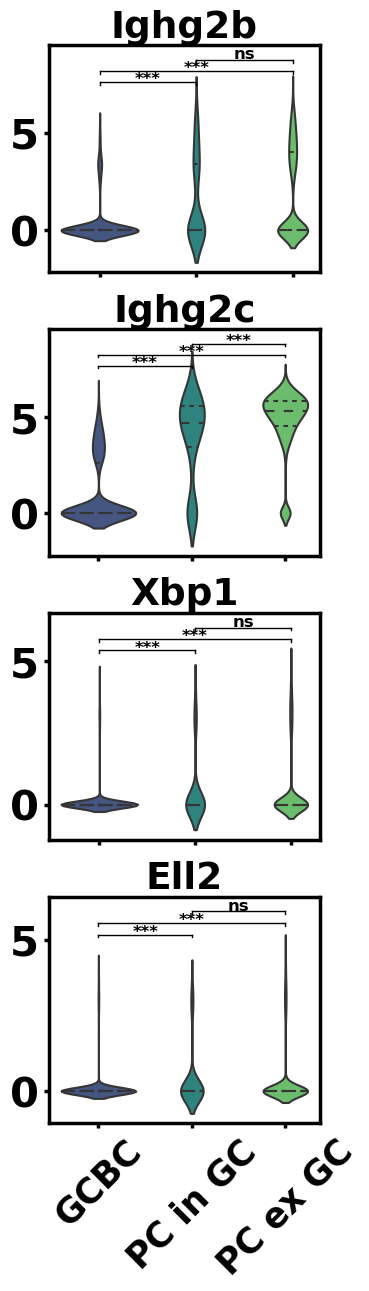




Ighg2b:
-------
  GCBC vs PC in GC: Mann–Whitney adj p = 2.88e-17 ***; equal
  GCBC vs PC ex GC: Mann–Whitney adj p = 9.38e-100 ***; equal
  PC in GC vs PC ex GC: Mann–Whitney adj p = 0.229 ns; equal

Ighg2c:
-------
  GCBC vs PC in GC: Mann–Whitney adj p = 1.33e-47 ***; GCBC < PC in GC
  GCBC vs PC ex GC: Mann–Whitney adj p = 0 ***; GCBC < PC ex GC
  PC in GC vs PC ex GC: Mann–Whitney adj p = 3.06e-06 ***; PC in GC < PC ex GC

Xbp1:
-----
  GCBC vs PC in GC: Mann–Whitney adj p = 1.04e-09 ***; equal
  GCBC vs PC ex GC: Mann–Whitney adj p = 1.94e-35 ***; equal
  PC in GC vs PC ex GC: Mann–Whitney adj p = 0.622 ns; equal

Ell2:
-----
  GCBC vs PC in GC: Mann–Whitney adj p = 2.93e-05 ***; equal
  GCBC vs PC ex GC: Mann–Whitney adj p = 1.18e-14 ***; equal
  PC in GC vs PC ex GC: Mann–Whitney adj p = 0.719 ns; equal


In [47]:
results_df = gene_expression_MWU_violin_plots(
    adata=C85_33_adata, gene_list=fig_s8H_genes, fig_title="s8H_violin_plot_no_points" , remove_zeros=False, show_points=False, show_sig=True
)

Jchain: 2667/4767 cells (55.9%) have 0 expression
  GCBC: 1167/1358 (85.9%)
  PC in GC: 56/110 (50.9%)
  PC ex GC: 1444/3299 (43.8%)
Ighg1: 2751/4767 cells (57.7%) have 0 expression
  GCBC: 1116/1358 (82.2%)
  PC in GC: 65/110 (59.1%)
  PC ex GC: 1570/3299 (47.6%)
Igkc: 339/4767 cells (7.1%) have 0 expression
  GCBC: 335/1358 (24.7%)
  PC in GC: 0/110 (0.0%)
  PC ex GC: 4/3299 (0.1%)
Calr: 1849/4767 cells (38.8%) have 0 expression
  GCBC: 966/1358 (71.1%)
  PC in GC: 30/110 (27.3%)
  PC ex GC: 853/3299 (25.9%)
Pdia4: 2071/4767 cells (43.4%) have 0 expression
  GCBC: 1151/1358 (84.8%)
  PC in GC: 37/110 (33.6%)
  PC ex GC: 883/3299 (26.8%)
Hspa5: 956/4767 cells (20.1%) have 0 expression
  GCBC: 769/1358 (56.6%)
  PC in GC: 9/110 (8.2%)
  PC ex GC: 178/3299 (5.4%)
Figure saved as: 7f_violin_plot_points.png


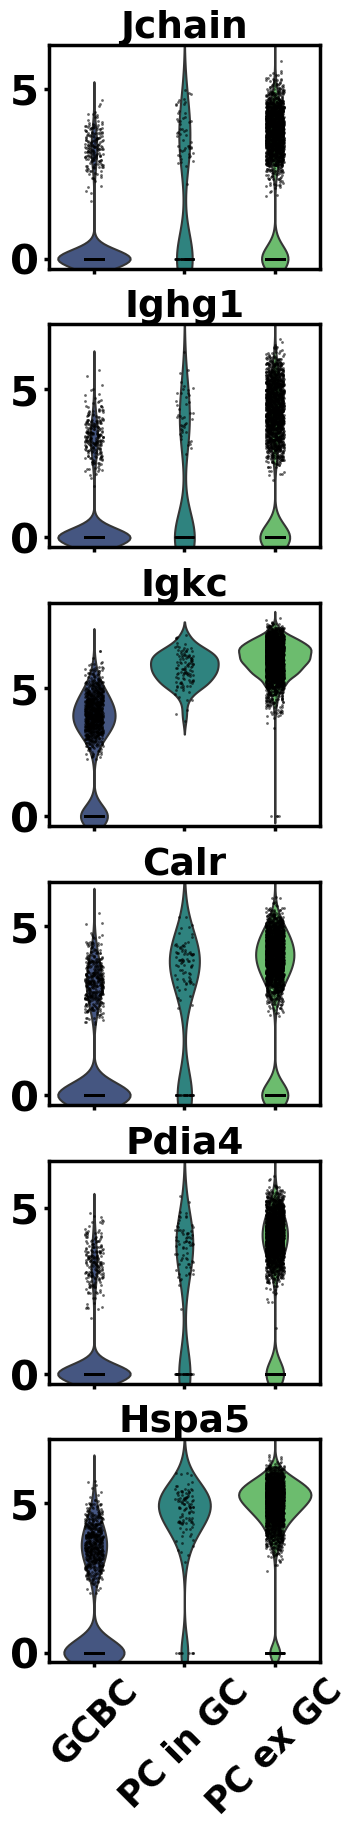




Jchain:
-------
  GCBC vs PC in GC: Mann–Whitney adj p = 1.23e-23 ***; equal
  GCBC vs PC ex GC: Mann–Whitney adj p = 1.39e-161 ***; GCBC < PC ex GC
  PC in GC vs PC ex GC: Mann–Whitney adj p = 0.0886 ns; PC in GC < PC ex GC

Ighg1:
------
  GCBC vs PC in GC: Mann–Whitney adj p = 1.93e-11 ***; equal
  GCBC vs PC ex GC: Mann–Whitney adj p = 5.33e-126 ***; GCBC < PC ex GC
  PC in GC vs PC ex GC: Mann–Whitney adj p = 0.00817 **; PC in GC < PC ex GC

Igkc:
-----
  GCBC vs PC in GC: Mann–Whitney adj p = 2.34e-60 ***; GCBC < PC in GC
  GCBC vs PC ex GC: Mann–Whitney adj p = 0 ***; GCBC < PC ex GC
  PC in GC vs PC ex GC: Mann–Whitney adj p = 4.51e-09 ***; PC in GC < PC ex GC

Calr:
-----
  GCBC vs PC in GC: Mann–Whitney adj p = 3.05e-30 ***; GCBC < PC in GC
  GCBC vs PC ex GC: Mann–Whitney adj p = 8.73e-231 ***; GCBC < PC ex GC
  PC in GC vs PC ex GC: Mann–Whitney adj p = 0.0449 *; PC in GC < PC ex GC

Pdia4:
------
  GCBC vs PC in GC: Mann–Whitney adj p = 3.9e-45 ***; GCBC < PC in GC
  GC

In [48]:
results_df = gene_expression_MWU_violin_plots(
    adata=C85_33_adata, gene_list=fig_7f_genes, fig_title="7f_violin_plot_points" , remove_zeros=False, show_points=True, show_sig=False
)

### Comparing Puck Gene Expression

In [49]:
# Must process another puck before gene expression across pucks can be compared

In [50]:
def norm_expr_one_gene(adata, gene):
    """
    Normalize gene count by total UMI count per bead. Scale expression by 10,000 and transform with log1p
    """
    if gene not in adata.var_names:
        raise KeyError(f"Gene '{gene}' not found in adata.var_names")
    # gene counts
    Xg = adata[:, [gene]].X
    if scipy.sparse.issparse(Xg):
        Xg = Xg.toarray().ravel()
    else:
        Xg = np.asarray(Xg).ravel()
    # total UMI per bead
    X = adata.X
    tot = X.sum(axis=1)
    if scipy.sparse.issparse(tot):
        tot = np.asarray(tot).ravel()
    else:
        tot = np.asarray(tot).ravel()
    tot[tot == 0] = 1  # avoid div-by-zero
    return np.log1p((Xg / tot) * 10000.0)

In [ ]:
def add_sig_brackets(ax, ordered, pair_pvals, y_max, y_range, fontsize=14):
    positions = {
        ("GCBC", "PC in GC"): (0, 1, y_max + 0.08 * y_range),
        ("GCBC", "PC ex GC"): (0, 2, y_max + 0.16 * y_range),
        ("PC in GC", "PC ex GC"): (1, 2, y_max + 0.24 * y_range),
    }

    for (g1, g2), pval in pair_pvals.items():
        if (g1, g2) not in positions:
            continue
        x1, x2, y = positions[(g1, g2)]
        ax.plot([x1, x2], [y, y], "k-", linewidth=1)
        ax.plot([x1, x1], [y, y - 0.02 * y_range], "k-", linewidth=1)
        ax.plot([x2, x2], [y, y - 0.02 * y_range], "k-", linewidth=1)

        if pval < 0.001:
            text = "***"
        elif pval < 0.01:
            text = "**"
        elif pval < 0.05:
            text = "*"
        else:
            text = "ns"

        ax.text(
            (x1 + x2) / 2,
            y - 0.01 * y_range,
            text,
            ha="center",
            va="bottom",
            fontweight="bold",
            fontsize=fontsize
        )

In [ ]:
def grouped_violin_two_adatas_MWU(adata1, adata2, genes,
                                  adata1_label="adata1", adata2_label="adata2",
                                  gcbc_col="GCBC_not_PC", pcgc_col="PCGC",
                                  n_cols=3, fig_height=4.5, fig_width=6, fontsize=16,
                                  show_points=True, fig_title=None, legend_title=None):
    ordered = ["GCBC", "PC in GC", "PC ex GC"]

    def get_expr_by_group(adata, gene):
        ct = assign_cell_types_vectorized(adata, gcbc_col, pcgc_col)
        expr = norm_expr_one_gene(adata, gene)
        return {g: expr[ct == g] for g in ordered}

    def mannwhitney_raw(gdict):
        """Return raw p-values + direction for all pairs within one dataset."""
        pairs, raw_pvals, directions = [], [], []
        for i in range(len(ordered)):
            for j in range(i+1, len(ordered)):
                g1, g2 = ordered[i], ordered[j]
                if gdict[g1].size > 0 and gdict[g2].size > 0:
                    _, p = mannwhitneyu(gdict[g1], gdict[g2], alternative="two-sided")
                else:
                    p = np.nan
                pairs.append((g1, g2))
                raw_pvals.append(p)
                # directionality by median
                if gdict[g1].size > 0 and gdict[g2].size > 0:
                    med1, med2 = np.median(gdict[g1]), np.median(gdict[g2])
                    if med1 > med2:
                        directions.append(f"{g1} > {g2}")
                    elif med1 < med2:
                        directions.append(f"{g1} < {g2}")
                    else:
                        directions.append("equal")
                else:
                    directions.append("NA")
        return pairs, raw_pvals, directions

    n_rows = math.ceil(len(genes) / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(fig_width * n_cols, fig_height * n_rows))
    axes = np.array([axes]).flatten() if len(genes) == 1 else axes.flatten()

    results = []

    for i, gene in enumerate(genes):
        g1 = get_expr_by_group(adata1, gene)
        g2 = get_expr_by_group(adata2, gene)

        # dataframe for plotting
        df_gene = []
        for g in ordered:
            for val in g1[g]:
                df_gene.append({"Gene": gene, "Cell Type": g, "Expression": val, "Dataset": adata1_label})
            for val in g2[g]:
                df_gene.append({"Gene": gene, "Cell Type": g, "Expression": val, "Dataset": adata2_label})
        df_gene = pd.DataFrame(df_gene)

        # plot
        sns.violinplot(data=df_gene, x="Cell Type", y="Expression",
                       hue="Dataset", split=True, ax=axes[i], order=ordered,
                       inner=None, cut=0)
        if show_points:
            sns.stripplot(data=df_gene, x="Cell Type", y="Expression",
                          hue="Dataset", dodge=True, ax=axes[i],
                          order=ordered, color="black", size=2, alpha=0.5)

        axes[i].set_title(gene, fontsize=fontsize + 2, fontweight="bold")
        axes[i].set_ylabel("Scaled + Normalized Expression", fontsize=fontsize)
        axes[i].set_xlabel("")
        axes[i].tick_params(axis="x", rotation=45, labelsize=fontsize)
        axes[i].tick_params(axis="y", labelsize=fontsize)

        # legend
        handles, labels = axes[i].get_legend_handles_labels()
        if i == 0:
            axes[i].legend(handles[:2], labels[:2],
                           bbox_to_anchor=(1.05, 1), loc="upper left",
                           borderaxespad=0., title=legend_title,
                           title_fontsize=fontsize, fontsize=fontsize)
        else:
            axes[i].get_legend().remove()

        # MWU raw p-values
        pairs1, raw1, dir1 = mannwhitney_raw(g1)
        pairs2, raw2, dir2 = mannwhitney_raw(g2)

        # Fisher combine raw p-values across datasets
        combined_p = {}
        for pair in [("GCBC", "PC in GC"), ("GCBC", "PC ex GC"), ("PC in GC", "PC ex GC")]:
            idx1, idx2 = pairs1.index(pair), pairs2.index(pair)
            pvals = [p for p in [raw1[idx1], raw2[idx2]] if not pd.isna(p)]
            if pvals:
                _, p_comb = combine_pvalues(pvals, method="fisher")
                combined_p[pair] = p_comb

        # Holm-Bonferroni correction across the 3 combined comparisons
        if combined_p:
            _, pvals_adj, _, _ = multipletests(list(combined_p.values()), method="holm")
            combined_p_adj = dict(zip(combined_p.keys(), pvals_adj))
        else:
            combined_p_adj = {}

        # add significance brackets
        if len(df_gene) > 0 and combined_p_adj:
            y_max = df_gene["Expression"].max()
            y_range = df_gene["Expression"].max() - df_gene["Expression"].min()
            add_sig_brackets(axes[i], ordered, combined_p_adj, y_max, y_range)

        # print stats
        print(f"\n{gene}:")
        print(f"  {adata1_label}: raw MWU p-values = {dict(zip(pairs1, raw1))}")
        print(f"  {adata2_label}: raw MWU p-values = {dict(zip(pairs2, raw2))}")
        if combined_p:
            print("  Fisher combined p-values (raw):")
            for pair, p in combined_p.items():
                print(f"    {pair}: p={p:.3g}")
        if combined_p_adj:
            print("  Holm-adjusted (across 3 pairs) after Fisher:")
            for pair, p in combined_p_adj.items():
                sig = ("***" if p < 0.001 else
                       "**" if p < 0.01 else
                       "*" if p < 0.05 else "ns")
                print(f"    {pair}: p={p:.3g} {sig}")

        results.append({
            "gene": gene,
            "mw1_raw": dict(zip(pairs1, raw1)),
            "mw2_raw": dict(zip(pairs2, raw2)),
            "fisher_combined": combined_p,
            "fisher_holm": combined_p_adj
        })

    for j in range(len(genes), len(axes)):
        axes[j].set_visible(False)

    if fig_title and isinstance(fig_title, str) and fig_title.strip():
        save_figure(fig_title)

    plt.tight_layout()
    plt.show()

    return pd.DataFrame(results)

In [ ]:
results_df = grouped_violin_two_adatas_MWU(C85_33_adata, C85_7_adata, ["Irf4"], adata1_label="Replicate 1", adata2_label="Replicate 2", fig_title="Irf4_violin_comparison_points", show_points=True, legend_title="CD4bs-Int\u00B9")

In [ ]:
results_df = grouped_violin_two_adatas_MWU(C85_33_adata, C85_7_adata, ["Irf4"], adata1_label="Replicate 1", adata2_label="Replicate 2", fig_title="Irf4_violin_comparison_no_points", show_points=False, legend_title="CD4bs-Int\u00B9")

In [ ]:
results_df = grouped_violin_two_adatas_MWU(C85_33_adata, C85_7_adata, ["Sdc1"], adata1_label="Replicate 1", adata2_label="Replicate 2", fig_title="Sdc1_violin_comparison_points", show_points=True, legend_title="CD4bs-Int\u00B9")

In [ ]:
results_df = grouped_violin_two_adatas_MWU(C85_33_adata, C85_7_adata, ["Sdc1"], adata1_label="Replicate 1", adata2_label="Replicate 2", fig_title="Sdc1_violin_comparison_no_points", show_points=False, legend_title="CD4bs-Int\u00B9")

In [ ]:
results_df = grouped_violin_two_adatas(C85_33_adata, C85_7_adata, ["Sdc1"], adata1_label="Replicate 1", adata2_label="Replicate 2", fig_title="Sdc1_violin_comparison", legend_title="CD4bs-Int\u00B9")

### Comaring Puck Gene Set Expression

In [ ]:
def grouped_violin_geneset_scores_MWU(
    adata1, adata2, geneset,
    labels=("adata1", "adata2"),
    set_name="Gene_Set",
    gcbc_col="GCBC_not_PC",
    pcgc_col="PCGC",
    use_raw=False,
    ctrl_size=50,
    n_bins=25,
    fontsize=16,
    fig_height=4.5,
    fig_width=6,
    show_points=True,
    fig_title=None,
    legend_title=None
):
    """
    Make grouped violin plots of gene set scores across two adatas,
    grouped by cell types (GCBC, PC in GC, PC ex GC). 
    Calculate gene set score using scanpy score_genes.
    Uses Mann–Whitney U tests (Holm correction) per dataset and Fisher's method for combined p-values.
    """

    ordered = ["GCBC", "PC in GC", "PC ex GC"]

    # score genes for each adata
    def score_and_group(adata, label):
        valid_genes = [g for g in geneset if g in adata.var_names]
        if not valid_genes:
            raise ValueError(f"No valid genes from {set_name} found in {label}")
        score_col = f"{set_name}_score"
        sc.tl.score_genes(
            adata,
            gene_list=valid_genes,
            score_name=score_col,
            use_raw=use_raw,
            ctrl_size=ctrl_size,
            n_bins=n_bins
        )
        ct = assign_cell_types_vectorized(adata, gcbc_col, pcgc_col)
        scores = adata.obs[score_col].values
        return {g: scores[ct == g] for g in ordered}, score_col

    def mannwhitney_raw(gdict):
        pairs, raw_pvals, directions = [], [], []
        for i in range(len(ordered)):
            for j in range(i+1, len(ordered)):
                g1, g2 = ordered[i], ordered[j]
                if gdict[g1].size > 0 and gdict[g2].size > 0:
                    _, p = mannwhitneyu(gdict[g1], gdict[g2], alternative="two-sided")
                else:
                    p = np.nan
                pairs.append((g1, g2))
                raw_pvals.append(p)
                # directionality
                if gdict[g1].size > 0 and gdict[g2].size > 0:
                    med1, med2 = np.median(gdict[g1]), np.median(gdict[g2])
                    if med1 > med2: directions.append(f"{g1} > {g2}")
                    elif med1 < med2: directions.append(f"{g1} < {g2}")
                    else: directions.append("equal")
                else:
                    directions.append("NA")
        return pairs, raw_pvals, directions

    # Score genes and group by cell type
    g1, col1 = score_and_group(adata1, labels[0])
    g2, col2 = score_and_group(adata2, labels[1])

    # Build DataFrame for plotting
    df_plot = []
    for g in ordered:
        for val in g1[g]:
            df_plot.append({"Cell Type": g, "Score": val, "Dataset": labels[0]})
        for val in g2[g]:
            df_plot.append({"Cell Type": g, "Score": val, "Dataset": labels[1]})
    df_plot = pd.DataFrame(df_plot)

    # Plotting
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))
    sns.violinplot(
        data=df_plot,
        x="Cell Type", y="Score", hue="Dataset",
        order=ordered, split=True, inner=None,
        ax=ax, cut=0
    )
    if show_points:
        sns.stripplot(
            data=df_plot,
            x="Cell Type", y="Score", hue="Dataset",
            order=ordered, dodge=True, color="black",
            alpha=0.5, size=2, ax=ax
        )

    # Tidy legend
    handles, leg_labels = ax.get_legend_handles_labels()
    ax.legend(handles[:2], leg_labels[:2],
              bbox_to_anchor=(1.05, 1), loc="upper left",
              borderaxespad=0., title=legend_title, fontsize=fontsize, title_fontsize=fontsize)

    ax.set_title(f"{set_name}", fontsize=fontsize+2, fontweight="bold")
    ax.set_ylabel("Gene set score", fontsize=fontsize)
    ax.set_xlabel("")
    ax.tick_params(axis="x", rotation=45, labelsize=fontsize)
    ax.tick_params(axis="y", labelsize=fontsize)

# Mann–Whitney raw p-values
    pairs1, raw1, dir1 = mannwhitney_raw(g1)
    pairs2, raw2, dir2 = mannwhitney_raw(g2)

    # Combine raw p-values with Fisher's method
    combined_p_raw = {}
    for pair in [("GCBC","PC in GC"), ("GCBC","PC ex GC"), ("PC in GC","PC ex GC")]:
        pvals = []
        idx = pairs1.index(pair)
        if not pd.isna(raw1[idx]): pvals.append(raw1[idx])
        idx = pairs2.index(pair)
        if not pd.isna(raw2[idx]): pvals.append(raw2[idx])
        if pvals:
            _, p_comb = combine_pvalues(pvals, method="fisher")
            combined_p_raw[pair] = p_comb

  # Holm correction across the 3 combined comparisons
    if combined_p_raw:
        _, pvals_adj, _, _ = multipletests(list(combined_p_raw.values()), method="holm")
        combined_p_adj = dict(zip(combined_p_raw.keys(), pvals_adj))
    else:
        combined_p_adj = {}

    # significance brackets
    if combined_p_adj:
        y_max = df_plot["Score"].max()
        y_range = df_plot["Score"].max() - df_plot["Score"].min()
        add_sig_brackets(ax, ordered, combined_p_adj, y_max, y_range)

    if fig_title and isinstance(fig_title, str) and fig_title.strip():
        save_figure(fig_title)

    plt.tight_layout()
    plt.show()

    # print stats
    print(f"\nGene set: {set_name}")
    print(f"  {labels[0]} raw MWU p-values: {dict(zip(pairs1, raw1))}")
    print(f"  {labels[1]} raw MWU p-values: {dict(zip(pairs2, raw2))}")
    if combined_p_raw:
        print("  Fisher combined raw p-values:")
        for pair, p in combined_p_raw.items():
            print(f"    {pair}: p={p:.3g}")
    if combined_p_adj:
        print("  Holm-adjusted after Fisher:")
        for pair, p in combined_p_adj.items():
            sig = ("***" if p < 0.001 else
                   "**" if p < 0.01 else
                   "*" if p < 0.05 else "ns")
            print(f"    {pair}: p={p:.3g} {sig}")

    return {"adata1_raw": raw1, "adata2_raw": raw2,
            "combined_raw": combined_p_raw, "combined_holm": combined_p_adj}

In [ ]:
stats = grouped_violin_geneset_scores_MWU(
    C85_33_adata, C85_7_adata,
    geneset=["Mki67", "Cdk1", "Top2a", "Pcna"],
    labels=("Replicate 1", "Replicate 2"),
    set_name="Proliferation",
    fig_title="Proliferation_gene_set_violins_points",
    show_points=True,
    legend_title="CD4bs-Int\u00B9"
)

In [ ]:
stats = grouped_violin_geneset_scores_MWU(
    C85_33_adata, C85_7_adata,
    geneset=["Mki67", "Cdk1", "Top2a", "Pcna"],
    labels=("Replicate 1", "Replicate 2"),
    set_name="Proliferation",
    fig_title="Proliferation_gene_set_violins_no_points",
    show_points=False,
    legend_title="CD4bs-Int\u00B9"
)

## Distance analysis

### Center of Mass

In [51]:
def assign_gc_id(
    adata_file,
    radius=50.0,
    min_size=10,
    out_col="GC_id",
    na_label="NA"
):
    gc_mask = (adata_file.obs["GC"] == "True").to_numpy()
    coords = adata_file.obs[["x", "y"]].to_numpy()

    n = adata_file.n_obs
    gc_idx = np.where(gc_mask)[0]
    # create column called GC_id, index is bc
    out = pd.Series([na_label] * n, index=adata_file.obs_names, dtype="object")

    # Convert to a Tree
    tree = cKDTree(coords)
    nbrs = tree.query_ball_point(coords, r=radius)

    # Create Adjacency matrix
    gc_pos = {i: j for j, i in enumerate(gc_idx)}
    rows, cols = [], []
    for i in gc_idx:
        # keep only neighbors that are in GCs
        neigh = [j for j in nbrs[i] if gc_mask[j]]
        rows.extend([gc_pos[i]] * len(neigh))
        cols.extend([gc_pos[j] for j in neigh])

    m = len(gc_idx)
    if len(rows) == 0:
        # each GC spot is its own component
        A = csr_matrix((m, m), dtype=np.uint8)
    else:
        A = csr_matrix((np.ones(len(rows), dtype=np.uint8), (rows, cols)), shape=(m, m))
        # make adjacency matrix symm 
        A = ((A + A.T) > 0).astype(np.uint8)

    # Find connected points
    n_comp, labels = connected_components(A, directed=False)
    labels_series = pd.Series(labels, index=gc_idx)

    # sizes and filtering
    sizes = labels_series.value_counts().sort_index()
    keep_labels = set(sizes[sizes >= min_size].index)
    labels_filtered = labels_series.where(labels_series.isin(keep_labels), other=-1)

    kept_mask = labels_filtered != -1
    kept = labels_filtered[kept_mask]
    out.iloc[kept.index] = kept.astype(int).astype(str)
    
    comp_df = pd.DataFrame({
        "label": np.arange(n_comp, dtype=int),
        "size": sizes.reindex(range(n_comp), fill_value=0).values,
        "kept": [lab in keep_labels for lab in range(n_comp)]
    })

    adata_file.obs[out_col] = pd.Categorical(out.values)

    return {
        "n_components": int(n_comp),
        "component_sizes": sizes.to_dict(),
        "kept_components": sorted(int(x) for x in keep_labels),
        "components": comp_df,
        "assignments": out.copy
    }

In [52]:
stats = assign_gc_id(C85_33_adata, radius=45.0, min_size=5)
print(stats)

{'n_components': 11, 'component_sizes': {0: 376, 1: 100, 2: 393, 3: 70, 4: 262, 5: 151, 6: 15, 7: 14, 8: 127, 9: 42, 10: 28}, 'kept_components': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'components':     label  size  kept
0       0   376  True
1       1   100  True
2       2   393  True
3       3    70  True
4       4   262  True
5       5   151  True
6       6    15  True
7       7    14  True
8       8   127  True
9       9    42  True
10     10    28  True, 'assignments': <bound method NDFrame.copy of TACAGCCCCTGCTT    NA
TAGACTCGACTTCC    NA
AGACTGGTCCCCGC    NA
TCGTCTCTGAAGTC    NA
AAGGCCGACTTCGC    NA
                  ..
GACTCGTATTGTAC    NA
GGATAGAATCAGAC    NA
AAGTACGTGAAAGC    NA
GCTGCTGGTCCCCC    NA
GCCAAAATGCATCC    NA
Length: 25209, dtype: object>}


In [53]:
# find distance of each point to GC center
valid_gc = C85_33_adata.obs["GC_id"].notna() & (~C85_33_adata.obs["GC_id"].astype(str).str.upper().eq("NA"))
gc_centers = (
    C85_33_adata.obs.loc[valid_gc]
    .groupby("GC_id")[["x", "y"]].mean()
    .rename(columns={"x": "GC_center_x", "y": "GC_center_y"})
)

C85_33_adata.obs = C85_33_adata.obs.merge(gc_centers, left_on="GC_id", right_index=True, how="left")
C85_33_adata.obs["GC_center_dist"] = np.sqrt(
    (C85_33_adata.obs["x"] - C85_33_adata.obs["GC_center_x"])**2
  + (C85_33_adata.obs["y"] - C85_33_adata.obs["GC_center_y"])**2
)
C85_33_adata.obs.loc[~valid_gc, "GC_center_dist"] = np.nan
C85_33_adata.obs

nCount_RNA  nFeature_RNA  numReads  log10_numReads  \
TACAGCCCCTGCTT       927.0           504      6908        3.839352   
TAGACTCGACTTCC        65.0            50       374        2.572872   
AGACTGGTCCCCGC      1605.0           743     10832        4.034709   
TCGTCTCTGAAGTC      1043.0           582      6596        3.819281   
AAGGCCGACTTCGC       403.0           284      2695        3.430559   
...                    ...           ...       ...             ...   
GACTCGTATTGTAC        10.0            10        14        1.146128   
GGATAGAATCAGAC        10.0             7        11        1.041393   
AAGTACGTGAAAGC        11.0            11        13        1.113943   
GCTGCTGGTCCCCC        13.0             7        16        1.204120   
GCCAAAATGCATCC        10.0             9        10        1.000000   

                log10_nCount_RNA  log10_nFeature_RNA  pct_rrna  percent.rp  \
TACAGCCCCTGCTT          2.967080            2.702431  0.084142    0.009709   
TAGACTCGACTTCC          1.812913            1.698970  0.076923    0.000000   
AGACTGGTCCCCGC          3.205475            2.870989  0.125857    0.015576   
TCGTCTCTGAAGTC          3.018284            2.764923  0.081496    0.023011   
AAGGCCGACTTCGC          2.605305            2.453318  0.136476    0.054591   
...                          ...                 ...       ...         ...   
GACTCGTATTGTAC          1.000000            1.000000  0.000000    0.000000   
GGATAGAATCAGAC          1.000000            0.845098  0.300000    0.000000   
AAGTACGTGAAAGC          1.041393            1.041393  0.000000    0.090909   
GCTGCTGGTCCCCC          1.113943            0.845098  0.538462    0.000000   
GCCAAAATGCATCC          1.000000            0.954243  0.000000    0.000000   

                percent.mt  nCount_SCT  ...     PC   PCGC GCBC_not_PC  \
TACAGCCCCTGCTT    0.002157       101.0  ...   True  False       False   
TAGACTCGACTTCC    0.000000        79.0  ...  False     NA       False   
AGACTGGTCCCCGC    0.002492        80.0  ...   True  False       False   
TCGTCTCTGAAGTC    0.000000        83.0  ...   True  False       False   
AAGGCCGACTTCGC    0.000000        55.0  ...  False     NA       False   
...                    ...         ...  ...    ...    ...         ...   
GACTCGTATTGTAC    0.000000        46.0  ...  False     NA       False   
GGATAGAATCAGAC    0.000000        55.0  ...  False     NA       False   
AAGTACGTGAAAGC    0.000000        42.0  ...  False     NA       False   
GCTGCTGGTCCCCC    0.000000        65.0  ...  False     NA       False   
GCCAAAATGCATCC    0.000000        45.0  ...  False     NA       False   

               cell_type  Gene_Set_score  Gene_Set_summed_expr GC_id  \
TACAGCCCCTGCTT  PC ex GC            1.57              6.652517    NA   
TAGACTCGACTTCC     Other            0.47              5.732345    NA   
AGACTGGTCCCCGC  PC ex GC            0.72              3.255097    NA   
TCGTCTCTGAAGTC  PC ex GC            1.31              6.676986    NA   
AAGGCCGACTTCGC     Other            0.11              3.250913    NA   
...                  ...             ...                   ...   ...   
GACTCGTATTGTAC     Other            0.00              0.000000    NA   
GGATAGAATCAGAC     Other            0.00              0.000000    NA   
AAGTACGTGAAAGC     Other            0.00              0.000000    NA   
GCTGCTGGTCCCCC     Other            0.00              0.000000    NA   
GCCAAAATGCATCC     Other            0.00              0.000000    NA   

               GC_center_x GC_center_y GC_center_dist  
TACAGCCCCTGCTT         NaN         NaN            NaN  
TAGACTCGACTTCC         NaN         NaN            NaN  
AGACTGGTCCCCGC         NaN         NaN            NaN  
TCGTCTCTGAAGTC         NaN         NaN            NaN  
AAGGCCGACTTCGC         NaN         NaN            NaN  
...                    ...         ...            ...  
GACTCGTATTGTAC         NaN         NaN            NaN  
GGATAGAATCAGAC         NaN         NaN          

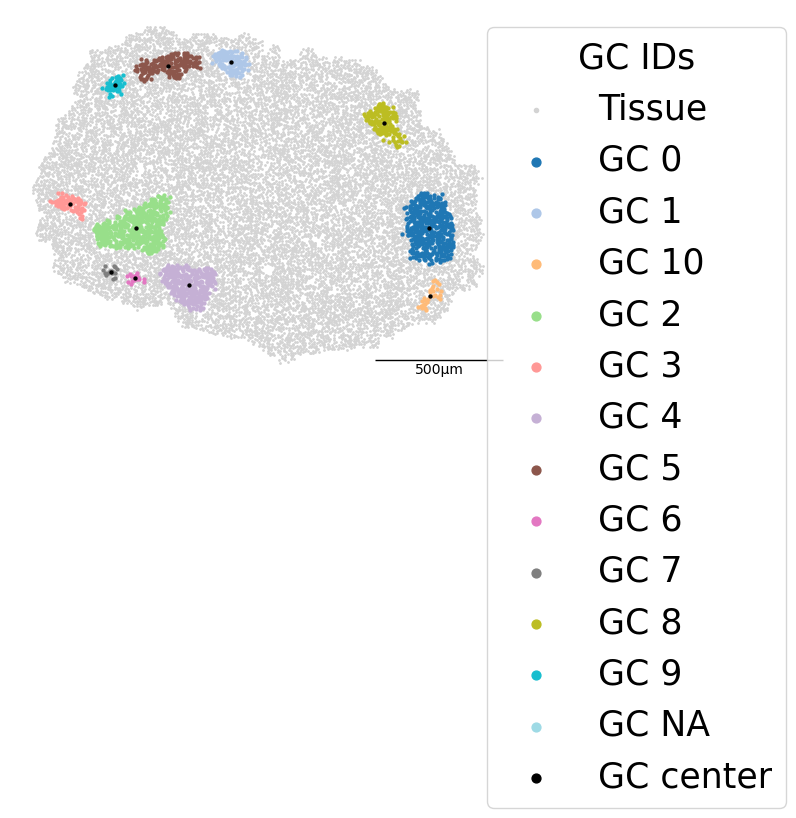

In [54]:
# plot individual GCs
valid_gcs = C85_33_adata.obs["GC_id"].notna() & (~C85_33_adata.obs["GC_id"].str.strip().str.upper().eq("NA"))
tissue_mask = (C85_33_adata.obs["Tissue"] == "True") & (~valid_gcs)

gc_cats = pd.Categorical(C85_33_adata.obs.loc[valid_gcs, "GC_id"])
gc_codes = gc_cats.codes 
cmap = plt.cm.get_cmap("tab20", len(gc_cats.categories))
gc_colors = cmap(gc_codes)

fig, ax = plt.subplots()

# plot tissue as background
ax.scatter(x = C85_33_adata.obs.loc[tissue_mask, "x"],
           y = C85_33_adata.obs.loc[tissue_mask, "y"],
           s=1,
           color = "lightgrey",
           label="Tissue")

for i, cat in enumerate(gc_cats.categories):
    mask = valid_gcs & (C85_33_adata.obs["GC_id"] == cat)
    ax.scatter(
        x=C85_33_adata.obs.loc[mask, "x"],
        y=C85_33_adata.obs.loc[mask, "y"],
        s=4.5,
        color=cmap(i),
        label=f"GC {cat}"
    )

# plot gc centers
ax.scatter(x=gc_centers["GC_center_x"],
           y=gc_centers["GC_center_y"],
           s=4.5,
           c="black",
           label= "GC center")

ax.legend(
    loc="upper right",
    bbox_to_anchor=(1.6, 1),
    markerscale=3,
    title="GC IDs"
)

ax.axis("off")
add_scale_bar(ax)

plt.show()

In [55]:
def alpha_shape_polygon(points_xy, alpha=1.5):
    """
    Create an alpha shape from each gc
    
    Returns a shapely Polygon or MultiPolygon
    """
    pts = np.asarray(points_xy, dtype=float)
    n = len(pts)
    if n < 4:
        return MultiPoint(pts).convex_hull

    # Delaunay triangulation
    tri = Delaunay(pts)

    # collect edges of triangles whose circumradius < 1/alpha
    edges = set()
    for ia, ib, ic in tri.simplices:
        pa, pb, pc = pts[ia], pts[ib], pts[ic]
        a = np.linalg.norm(pa - pb)
        b = np.linalg.norm(pb - pc)
        c = np.linalg.norm(pc - pa)
        s = 0.5 * (a + b + c)
        area_sq = max(s * (s - a) * (s - b) * (s - c), 0.0)
        if area_sq == 0.0:
            continue
        area = np.sqrt(area_sq)
        circum_r = (a * b * c) / (4.0 * area)

        if circum_r < (1.0 / alpha):
            for i, j in ((ia, ib), (ib, ic), (ic, ia)):
                e = (min(i, j), max(i, j))
                edges.add(e)

    if not edges:
        return MultiPoint(pts).convex_hull

    # Turn kept edges into lines, polygonize them, and union the polygons
    edge_lines = [LineString([pts[i], pts[j]]) for (i, j) in edges]
    mls = unary_union(edge_lines)
    polys = list(polygonize(mls))
    if not polys:
        return MultiPoint(pts).convex_hull
    return unary_union(polys)

def gc_alpha_boundaries(
    adata,
    gc_col="GC_id",
    x_col="x",
    y_col="y",
    kept_labels=None,
    alpha=1.5, 
    min_points_for_alpha=4
):
    """
    Build concave boundaries per GC component using the alpha_shape_polygon helper function.
    Returns:
      - polygons: dict[label] -> shapely (Multi)Polygon
      - boundaries: dict[label] -> np.ndarray (N,2) of exterior coords
      - info: pd.DataFrame with columns [label, n_points, alpha_used]
    """
    labs = adata.obs[gc_col].astype(str)

    if kept_labels is None:
        kept_labels = sorted(l for l in labs.dropna().unique()
                             if l.upper() not in {"NA", "<NA>", "NAN"})

    polygons, boundaries, records = {}, {}, []

    for lab in kept_labels:
        mask = (labs == str(lab))
        pts = adata.obs.loc[mask, [x_col, y_col]].to_numpy(dtype=float, copy=False)
        npts = len(pts)
        if npts == 0:
            continue

        if npts < min_points_for_alpha:
            poly = MultiPoint(pts).convex_hull
            alpha_used = "convex_hull"
        else:
            poly = alpha_shape_polygon(pts, alpha=float(alpha))
            alpha_used = float(alpha)

        try:
            poly = poly.buffer(0)
        except Exception:
            pass

        # Use the largest component for boundary coords if it's a MultiPolygon
        if poly.geom_type == "MultiPolygon":
            poly_largest = max(list(poly.geoms), key=lambda p: p.area)
        else:
            poly_largest = poly

        if getattr(poly_largest, "exterior", None) is not None:
            xs, ys = poly_largest.exterior.coords.xy
            boundary_xy = np.c_[xs, ys]
        else:
            boundary_xy = pts  # degenerate fallback

        polygons[str(lab)]  = poly
        boundaries[str(lab)] = boundary_xy
        records.append({"label": str(lab), "n_points": int(npts), "alpha_used": alpha_used})

    info = pd.DataFrame.from_records(records).sort_values("label").reset_index(drop=True)
    adata.uns["gc_alpha_polygons"]   = polygons
    adata.uns["gc_alpha_boundaries"] = boundaries
    adata.uns["gc_alpha_info"]       = info
    return polygons, boundaries, info

In [56]:
gc_centers = gc_centers.drop(index="NA")
gc_centers

GC_center_x  GC_center_y
GC_id                          
0      3879.905053  2429.024734
1      2692.410000  3573.164000
10     3886.582143  1961.921429
2      2121.570483  2429.361578
3      1725.350000  2594.625714
4      2441.354198  2039.854580
5      2313.315894  3546.841722
6      2115.686667  2083.073333
7      1970.392857  2127.878571
8      3609.110236  3154.695276
9      1994.111905  3409.928571

In [57]:
def extract_boundary_coords(poly):
    """
    Extract exterior coordinates (Nx2) for a (Multi)Polygon.
    Also returns a list of holes (each an Mx2 array), if you need them.
    """
    exterior_xy = None
    holes = []

    if poly.is_empty:
        return exterior_xy, holes

    if poly.geom_type == "Polygon":
        if poly.exterior is not None:
            xs, ys = poly.exterior.coords.xy
            exterior_xy = np.c_[xs, ys]
        for ring in poly.interiors:
            xs, ys = ring.coords.xy
            holes.append(np.c_[xs, ys])

    elif poly.geom_type == "MultiPolygon":
        # choose the largest component for "main" exterior
        parts = list(poly.geoms)
        if len(parts) > 0:
            p_main = max(parts, key=lambda p: p.area)
            if p_main.exterior is not None:
                xs, ys = p_main.exterior.coords.xy
                exterior_xy = np.c_[xs, ys]
        # (optional) collect holes from all parts if desired
        for p in parts:
            for ring in p.interiors:
                xs, ys = ring.coords.xy
                holes.append(np.c_[xs, ys])

    return exterior_xy, holes


def make_centers_dict(gc_centers, drop_na=True):
    df = gc_centers.copy()
    if drop_na:
        df = df.dropna(how="any")

    # ensure index is str to match polygons/boundaries keys
    df.index = df.index.astype(str)

    return {str(idx): (float(row["GC_center_x"]), float(row["GC_center_y"]))
            for idx, row in df.iterrows()}


def shrink_gc_boundaries(
    polygons,
    centers=None,
    fraction=0.5,
    fallback_to_centroid=True
):
    """
    Homothetically shrink each GC polygon about its center by `fraction`.

    Parameters:
    - polygons : dict[label] -> shapely (Multi)Polygon
    - centers  : dict[label] -> (cx, cy) or None (use centroid if fallback_to_centroid)
    - fraction : float; radial scale factor about the given center
    - fallback_to_centroid : if True, use polygon centroid when center not provided

    Returns:
    - shrunk_polys  : dict[label] -> shapely (Multi)Polygon
    - shrunk_bounds : dict[label] -> {"exterior": Nx2 array, "holes": [Mx2 arrays]}
    - shrink_info   : pd.DataFrame with columns:
                    ["label", "center_x", "center_y", "fraction", "area_before", "area_after"]
    """
    shrunk_polys = {}
    shrunk_bounds = {}
    records = []

    for lab, poly in polygons.items():
        # choose center
        if centers is not None and lab in centers:
            cx, cy = float(centers[lab][0]), float(centers[lab][1])
        else:
            # cannot shrink without a center
            if not fallback_to_centroid:
                continue
            c = poly.centroid
            cx, cy = float(c.x), float(c.y)

        # homothetic scaling about (cx, cy)
        sp = scale(poly, xfact=fraction, yfact=fraction, origin=(cx, cy))

        # repair invalid/self-intersecting geometries if any
        try:
            sp = sp.buffer(0)
        except Exception:
            pass

        exterior_xy, holes_xy = extract_boundary_coords(sp)

        shrunk_polys[lab] = sp
        shrunk_bounds[lab] = {"exterior": exterior_xy, "holes": holes_xy}
        records.append({
            "label": lab,
            "center_x": cx, "center_y": cy,
            "fraction": fraction,
            "area_before": float(poly.area) if hasattr(poly, "area") else np.nan,
            "area_after": float(sp.area) if hasattr(sp, "area") else np.nan
        })

    shrink_info = pd.DataFrame.from_records(records)
    return shrunk_polys, shrunk_bounds, shrink_info

def outer_boundary_polygon(poly, distance_um=30/0.65, resolution=16, join = JOIN_STYLE.round):
    """
    Return the polygon expanded outward by `distance_um`.
    """

    expanded = poly.buffer(distance_um, resolution=resolution, join_style=join)

    try:
        expanded = expanded.buffer(0)
    except Exception:
        pass
    return expanded

  label     center_x     center_y  fraction  area_before   area_after
0     0  3879.905053  2429.024734       0.5   122791.275  30697.81875
1     1  2692.410000  3573.164000       0.5    29177.595   7294.39875
2    10  3886.582143  1961.921429       0.5    14503.095   3625.77375
3     2  2121.570483  2429.361578       0.5   122749.205  30687.30125
4     3  1725.350000  2594.625714       0.5    20940.260   5235.06500


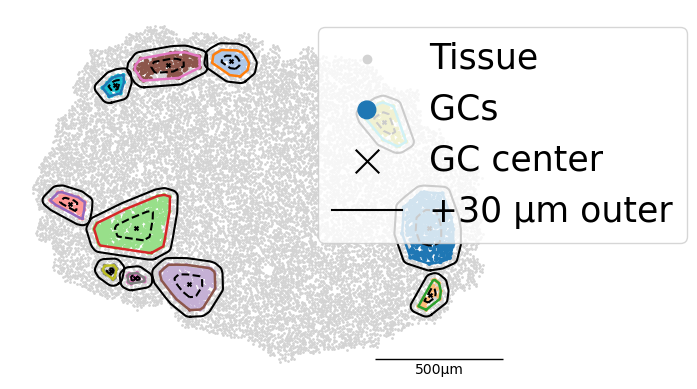

In [58]:
polys, bounds, info = gc_alpha_boundaries(
    C85_33_adata,
    gc_col="GC_id",
    x_col="x", y_col="y",
    alpha=1.5
)
centers = make_centers_dict(gc_centers, drop_na=True)

shrunk_polys, shrunk_bounds, shrink_info = shrink_gc_boundaries(
    polygons=polys,
    centers=centers,
    fraction=0.5
)
print(shrink_info.head())

fig, ax = plt.subplots()

# plot tissue as background
ax.scatter(
    x=C85_33_adata.obs.loc[tissue_mask, "x"],
    y=C85_33_adata.obs.loc[tissue_mask, "y"],
    s=1,
    color="lightgrey",
    label="Tissue"
)

# plot GC points
ax.scatter(
    x=C85_33_adata.obs.loc[valid_gcs, "x"],
    y=C85_33_adata.obs.loc[valid_gcs, "y"],
    s=4.5,
    c=gc_colors,
    label="GCs"
)

# plot GC centers
ax.scatter(
    x=gc_centers["GC_center_x"],
    y=gc_centers["GC_center_y"],
    s=8,
    c="black",
    marker="x",
    label="GC center"
)

# Outer boundaries (already plotted with `bounds`)
for lab, B in bounds.items():
    ax.plot(B[:,0], B[:,1], lw=1.8)

# Inner homothetic boundaries (dashed black)
for lab, Bdict in shrunk_bounds.items():
    ext = Bdict["exterior"]
    if ext is not None:
        ax.plot(ext[:,0], ext[:,1], lw=1.5, ls="--", color="black")
        
        
outer_polys = {lab: outer_boundary_polygon(poly, distance_um=30/0.65)
               for lab, poly in polys.items()}

outer_bounds = {}
for lab, poly in outer_polys.items():
    ext_xy, holes_xy = extract_boundary_coords(poly)
    outer_bounds[lab] = {"exterior": ext_xy, "holes": holes_xy}
for lab, Bdict in outer_bounds.items():
    ext = Bdict["exterior"]
    if ext is not None:
        ax.plot(ext[:,0], ext[:,1], lw=1.5, ls="-", color="black", label="+30 µm outer" if lab == list(outer_bounds.keys())[0] else None)

        
        
ax.axis("off")
add_scale_bar(ax)
ax.legend(loc="upper right", bbox_to_anchor=(1.4, 1), markerscale=6)

plt.show()

### GC Core vs. Ring

In [59]:
def points_to_series(adata, mask, x_col="x", y_col="y"):
    """
    Extract coordinates and barcode for specific beads.
    """
    pts = adata.obs.loc[mask, [x_col, y_col]].to_numpy(dtype=float, copy=False)
    idx = adata.obs.index[mask]
    return pts, idx

def classify_core_vs_ring_for_gc(
    adata,
    gc_id,
    outer_poly,
    inner_poly,
    gc_col="GC_id",
    x_col="x",
    y_col="y",
    pc_col="PCGC",
    return_dfs=True
):
    """
    Classify beads in a given GC into core vs ring regions.

    Returns
    -------
    labels : pd.Series
        Index-matched Series of region labels ("core", "ring", or None).
    core_df, ring_df : pd.DataFrame (optional)
        If return_dfs=True, also returns DataFrames of PCs in core and ring regions.
    """
    mask_gc = adata.obs[gc_col].astype(str) == str(gc_id)
    pts, idx = points_to_series(adata, mask_gc, x_col, y_col)
    if len(idx) == 0:
        if return_dfs:
            return pd.Series(dtype="object"), pd.DataFrame(columns=[x_col, y_col, "GC_id"]), pd.DataFrame(columns=[x_col, y_col, "GC_id"])
        return pd.Series(dtype="object")

    Pin  = prep(inner_poly)
    Pout = prep(outer_poly)

    labels = []
    for (x, y) in pts:
        pt = Point(x, y)
        if Pin.covers(pt):
            labels.append("core")
        elif Pout.covers(pt):
            labels.append("ring")
        else:
            labels.append(None)

    labels = pd.Series(labels, index=idx, dtype="object")

    if not return_dfs:
        return labels

    # Subset to PCs only
    df = adata.obs.loc[labels.index, [x_col, y_col, pc_col]].copy()
    df["region"] = labels.values
    df[pc_col] = df[pc_col].astype(str).str.strip().str.lower().eq("true")

    core_df = df.loc[(df["region"] == "core") & (df[pc_col]), [x_col, y_col]].copy()
    core_df["GC_id"] = gc_id

    ring_df = df.loc[(df["region"] == "ring") & (df[pc_col]), [x_col, y_col]].copy()
    ring_df["GC_id"] = gc_id

    return labels, core_df, ring_df

def fisher_core_vs_ring_overlay(
    adata,
    polygons,   
    shrunk_polys,
    gc_centers=None,
    gc_col="GC_id",
    pc_col="PCGC",
    min_size=50,
    x_col="x",
    y_col="y",
    plot=True,
    fig_title=None
):
    df = adata.obs.copy()
    valid = df[gc_col].notna() & (~df[gc_col].astype(str).str.strip().str.upper().eq("NA"))
    df = df.loc[valid].copy()
    df[pc_col] = df[pc_col].astype(str).str.strip().str.lower().eq("true")

    results, pvals = [], []
    gc_ids = sorted(set(polygons.keys()).intersection(shrunk_polys.keys()), key=str)
    
    overlay_points = []
    kept_gc_ids = []

    # collect PCs in core and ring for all GCs
    all_core_rows, all_ring_rows = [], []

    for gid in gc_ids:
        outer_poly = polygons[gid]
        inner_poly = shrunk_polys[gid]

        labels, core_df, ring_df = classify_core_vs_ring_for_gc(
            adata,
            gid,
            outer_poly,
            inner_poly,
            gc_col=gc_col,
            x_col=x_col,
            y_col=y_col,
            pc_col=pc_col,
            return_dfs=True
        )

        if labels.empty:
            continue

        g = df.loc[labels.index].copy()
        g["region"] = labels.values
        g = g[g["region"].isin(["core", "ring"])]

        if len(g) < min_size:
            continue

        kept_gc_ids.append(str(gid))
        overlay_points.append(g[[x_col, y_col, "region"]])

        if not core_df.empty:
            all_core_rows.append(core_df)
        if not ring_df.empty:
            all_ring_rows.append(ring_df)

        # create contingency table
        ct = pd.crosstab(g[pc_col], g["region"]).reindex(
            index=[False, True], columns=["core", "ring"], fill_value=0
        )

        # Extract counts
        a = int(ct.loc[True,  "core"])  # PC in core
        b = int(ct.loc[True,  "ring"])  # PC in ring
        c = int(ct.loc[False, "core"])  # non-PC in core
        d = int(ct.loc[False, "ring"])  # non-PC in ring

        table = np.array([[a, b],
                          [c, d]])

        if (a + b == 0) or (c + d == 0):
            odds, p = np.nan, np.nan
        else:
            odds, p = fisher_exact(table, alternative="less")
            pvals.append(p)

        results.append({
            "GC_id": gid,
            "n": int(len(g)),
            "core_PC":    a,
            "ring_PC":    b,
            "core_nonPC": c,
            "ring_nonPC": d,
            "odds_ratio": float(odds) if np.isfinite(odds) else np.nan,
            "fisher_p":   float(p)    if np.isfinite(p)    else np.nan,
        })

    summary = pd.DataFrame(results).sort_values("fisher_p", na_position="last")
    chi2_stat, fisher_meta_p = (combine_pvalues(pvals, method="fisher")
                                if len(pvals) else (np.nan, np.nan))

    if not summary.empty:
        print("Per-GC Fisher exact tests (core vs ring):")
        for _, r in summary.iterrows():
            print(f"  GC {r['GC_id']}: p = {r['fisher_p']:.3g} "
                  f"[n={r['n']}; core PC={r['core_PC']}, ring PC={r['ring_PC']}]")
    else:
        print("No GCs passed filters for Fisher testing.")

    print(f"\nFisher’s method (combined across GCs):")
    print(f"  chi2_stat = {chi2_stat:.3g}, combined p = {fisher_meta_p:.3g}")

    if plot and overlay_points:
        overlay_df = pd.concat(overlay_points, ignore_index=True)

        fig, ax = plt.subplots()
        if "Tissue" in adata.obs.columns:
            tissue_mask = adata.obs["Tissue"].astype(str).str.lower().eq("true")
            ax.scatter(adata.obs.loc[tissue_mask, x_col],
                       adata.obs.loc[tissue_mask, y_col],
                       s=1, color="lightgrey", label="Tissue")

        colors = {"core": "tab:blue", "ring": "tab:orange"}
        for region, color in colors.items():
            m = overlay_df["region"] == region
            if m.any():
                ax.scatter(overlay_df.loc[m, x_col],
                           overlay_df.loc[m, y_col],
                           s=6, color=color, label=region, zorder=2)

        if gc_centers is not None and kept_gc_ids:
            centers = gc_centers.copy()
            centers.index = centers.index.astype(str)
            centers = centers.loc[centers.index.intersection(kept_gc_ids)]
            centers = centers.dropna(subset=["GC_center_x", "GC_center_y"])
            if not centers.empty:
                ax.scatter(centers["GC_center_x"], centers["GC_center_y"],
                           s=25, color="black", marker="x", linewidths=0.9,
                           label="GC center", zorder=3)

        ax.axis("off")
        ax.legend(loc="upper right", bbox_to_anchor=(1.5, 1), borderaxespad=0.0, markerscale=2)
        ax.set_aspect("equal")
        add_scale_bar(ax)
        plt.tight_layout()
        if fig_title and isinstance(fig_title, str) and fig_title.strip():
            save_figure(fig_title)
        plt.show()
        
    # combine across GCs
    core_all = pd.concat(all_core_rows, ignore_index=True) if all_core_rows else pd.DataFrame(columns=[x_col, y_col, "GC_id"])
    ring_all = pd.concat(all_ring_rows, ignore_index=True) if all_ring_rows else pd.DataFrame(columns=[x_col, y_col, "GC_id"])

    meta = {"chi2_stat": chi2_stat, "fisher_meta_p": fisher_meta_p}
    return summary, meta, core_all, ring_all

Per-GC Fisher exact tests (core vs ring):
  GC 8: p = 0.00175 [n=127; core PC=0, ring PC=17]
  GC 4: p = 0.0113 [n=262; core PC=1, ring PC=23]
  GC 2: p = 0.0421 [n=393; core PC=1, ring PC=15]
  GC 1: p = 0.15 [n=100; core PC=0, ring PC=7]
  GC 0: p = 0.94 [n=376; core PC=4, ring PC=5]
  GC 5: p = 0.999 [n=151; core PC=11, ring PC=8]

Fisher’s method (combined across GCs):
  chi2_stat = 31.9, combined p = 0.00143
Figure saved as: inner_vs_outer_gcs.png


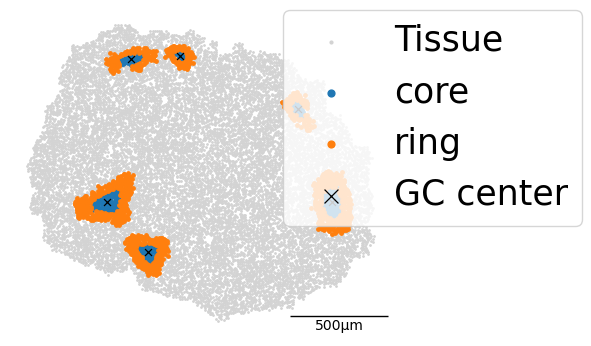

In [60]:
summary, meta, core_df, ring_df = fisher_core_vs_ring_overlay(
    adata=C85_33_adata,
    polygons=polys,
    shrunk_polys=shrunk_polys,
    gc_centers=gc_centers,
    gc_col="GC_id",
    pc_col="PCGC",
    min_size=100,
    plot=True,
    fig_title="inner_vs_outer_gcs"
)

### PCs around GC

In [61]:
def pcs_around_gc(
    adata,
    polygons,
    pc_col="PCGC",
    dist_pixels=30/0.65,
    x_col="x",
    y_col="y",
    include_boundaries=True,
    return_indices=False
):
    """
    For each GC polygon, count PCs between the GC boundary and an
    outward ring at `dist_pixels`. Returns a DataFrame of counts.
    """
    pc_series = adata.obs[pc_col].astype(str).str.strip().str.lower().eq("false")
    xs = adata.obs[x_col].to_numpy(dtype=float, copy=False)
    ys = adata.obs[y_col].to_numpy(dtype=float, copy=False)
    barcodes = adata.obs.index

    rows = []
    idx_map = {}

    for gid, gc_poly in polygons.items():
        if gc_poly.is_empty:
            rows.append({"GC_id": str(gid), "n_PC_in_periphery": 0})
            if return_indices:
                idx_map[str(gid)] = []
            continue

        try:
            gc_poly = gc_poly.buffer(0)
        except Exception:
            pass

        outer = gc_poly.buffer(dist_pixels)
        try:
            outer = outer.buffer(0)
        except Exception:
            pass

        annulus = outer.difference(gc_poly)
        if annulus.is_empty:
            rows.append({"GC_id": str(gid), "n_PC_in_periphery": 0})
            if return_indices:
                idx_map[str(gid)] = []
            continue

        minx, miny, maxx, maxy = annulus.bounds
        bbox_mask = (xs >= minx) & (xs <= maxx) & (ys >= miny) & (ys <= maxy)
        cand_mask = bbox_mask & pc_series.values
        cand_idx = np.where(cand_mask)[0]

        pcs_in_annulus = []
        if cand_idx.size:
            P = prep(annulus)
            for i in cand_idx:
                pt = Point(xs[i], ys[i])
                inside = P.covers(pt) if include_boundaries else P.contains(pt)
                if inside:
                    pcs_in_annulus.append(barcodes[i])

        rows.append({"GC_id": str(gid), "n_PC_in_periphery": len(pcs_in_annulus)})
        if return_indices:
            idx_map[str(gid)] = pcs_in_annulus

    out = pd.DataFrame(rows).sort_values("GC_id").reset_index(drop=True)
    return (out, idx_map) if return_indices else out

  label     center_x     center_y  fraction  area_before   area_after
0     0  3879.905053  2429.024734       0.5   122791.275  30697.81875
1     1  2692.410000  3573.164000       0.5    29177.595   7294.39875
2    10  3886.582143  1961.921429       0.5    14503.095   3625.77375
3     2  2121.570483  2429.361578       0.5   122749.205  30687.30125
4     3  1725.350000  2594.625714       0.5    20940.260   5235.06500


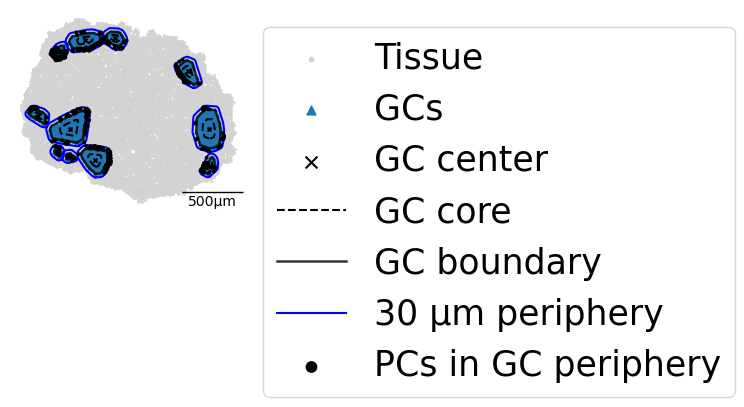

   GC_id  n_PC_in_periphery
0      0                 27
1      1                 24
2     10                 24
3      2                 52
4      3                 15
5      4                 57
6      5                 39
7      6                  4
8      7                  6
9      8                 38
10     9                 39


In [63]:
polys, bounds, info = gc_alpha_boundaries(
    C85_33_adata,
    gc_col="GC_id",
    x_col="x", y_col="y",
    alpha=1.5
)

centers = make_centers_dict(gc_centers, drop_na=True)

shrunk_polys, shrunk_bounds, shrink_info = shrink_gc_boundaries(
    polygons=polys,
    centers=centers,
    fraction=0.5
)
print(shrink_info.head())

outer_polys = {lab: outer_boundary_polygon(poly, distance_um=30/0.65, join=1)
               for lab, poly in polys.items()}

outer_bounds = {}
for lab, poly in outer_polys.items():
    ext_xy, holes_xy = extract_boundary_coords(poly)
    outer_bounds[lab] = {"exterior": ext_xy, "holes": holes_xy}

per_counts, per_idx = pcs_around_gc(
    C85_33_adata,
    polygons=polys,
    pc_col="PCGC",
    dist_pixels=30/0.65,
    x_col="x",
    y_col="y",
    include_boundaries=True,
    return_indices=True
)

# Combine periphery PC coordinates for plotting
periphery_rows = []
for gid, idx_list in per_idx.items():
    if not idx_list:
        continue
    sub = C85_33_adata.obs.loc[idx_list, ["x", "y"]].copy()
    sub["GC_id"] = gid
    periphery_rows.append(sub)
periphery_df = pd.concat(periphery_rows, ignore_index=True) if periphery_rows else pd.DataFrame(columns=["x","y","GC_id"])

# GC masks & colors
valid_gcs = C85_33_adata.obs["GC_id"].notna() & (~C85_33_adata.obs["GC_id"].astype(str).str.strip().str.upper().eq("NA"))
tissue_mask = (C85_33_adata.obs["Tissue"].astype(str).str.lower() == "true") & (~valid_gcs)

gc_cats = pd.Categorical(C85_33_adata.obs.loc[valid_gcs, "GC_id"].astype(str))
gc_codes = gc_cats.codes
cmap = plt.cm.get_cmap("tab20", len(gc_cats.categories))
gc_colors = cmap(gc_codes)

fig, ax = plt.subplots(figsize=(8, 8))

# tissue background
ax.scatter(
    x=C85_33_adata.obs.loc[tissue_mask, "x"],
    y=C85_33_adata.obs.loc[tissue_mask, "y"],
    s=1,
    color="lightgrey",
    label="Tissue"
)

# GC points
ax.scatter(
    x=C85_33_adata.obs.loc[valid_gcs, "x"],
    y=C85_33_adata.obs.loc[valid_gcs, "y"],
    s=4.5,
    c="C0",
    marker="^",
    label="GCs"
)

# GC centers
ax.scatter(
    x=gc_centers["GC_center_x"],
    y=gc_centers["GC_center_y"],
    s=8,
    c="black",
    marker="x",
    label="GC center"
)

# Inner shrunk boundaries (dashed)
first_label_done=False
for lab, Bdict in shrunk_bounds.items():
    ext = Bdict["exterior"]
    if ext is not None:
        ax.plot(ext[:, 0], ext[:, 1], lw=1.5, ls="--", color="black", label = "GC core" if not first_label_done else None)
        first_label_done=True
        
# Outer alpha-shape boundaries
first_gc_done=False
for lab, B in bounds.items():
    if B is not None:
        ax.plot(B[:, 0], B[:, 1], lw=1.8, color="k", alpha=0.8,
                label="GC boundary" if not first_gc_done else None
               )
        first_gc_done=True


# +30 µm outer boundaries
first_label_done = False
for lab, Bdict in outer_bounds.items():
    ext = Bdict["exterior"]
    if ext is not None:
        ax.plot(
            ext[:, 0], ext[:, 1],
            lw=1.5, ls="-", color="blue",
            label="30 µm periphery" if not first_label_done else None
        )
        first_label_done = True

# PCs in the 30 µm ring
if not periphery_df.empty:
    ax.scatter(
        periphery_df["x"], periphery_df["y"],
        s=8, c="black", edgecolors="none",
        label="PCs in GC periphery", zorder=3
    )

ax.axis("off")
ax.set_aspect("equal", adjustable="box")
add_scale_bar(ax)
ax.legend(loc="upper left", bbox_to_anchor=(1, 1), borderaxespad=0.5, markerscale=3)
plt.tight_layout()
plt.show()

print(per_counts)

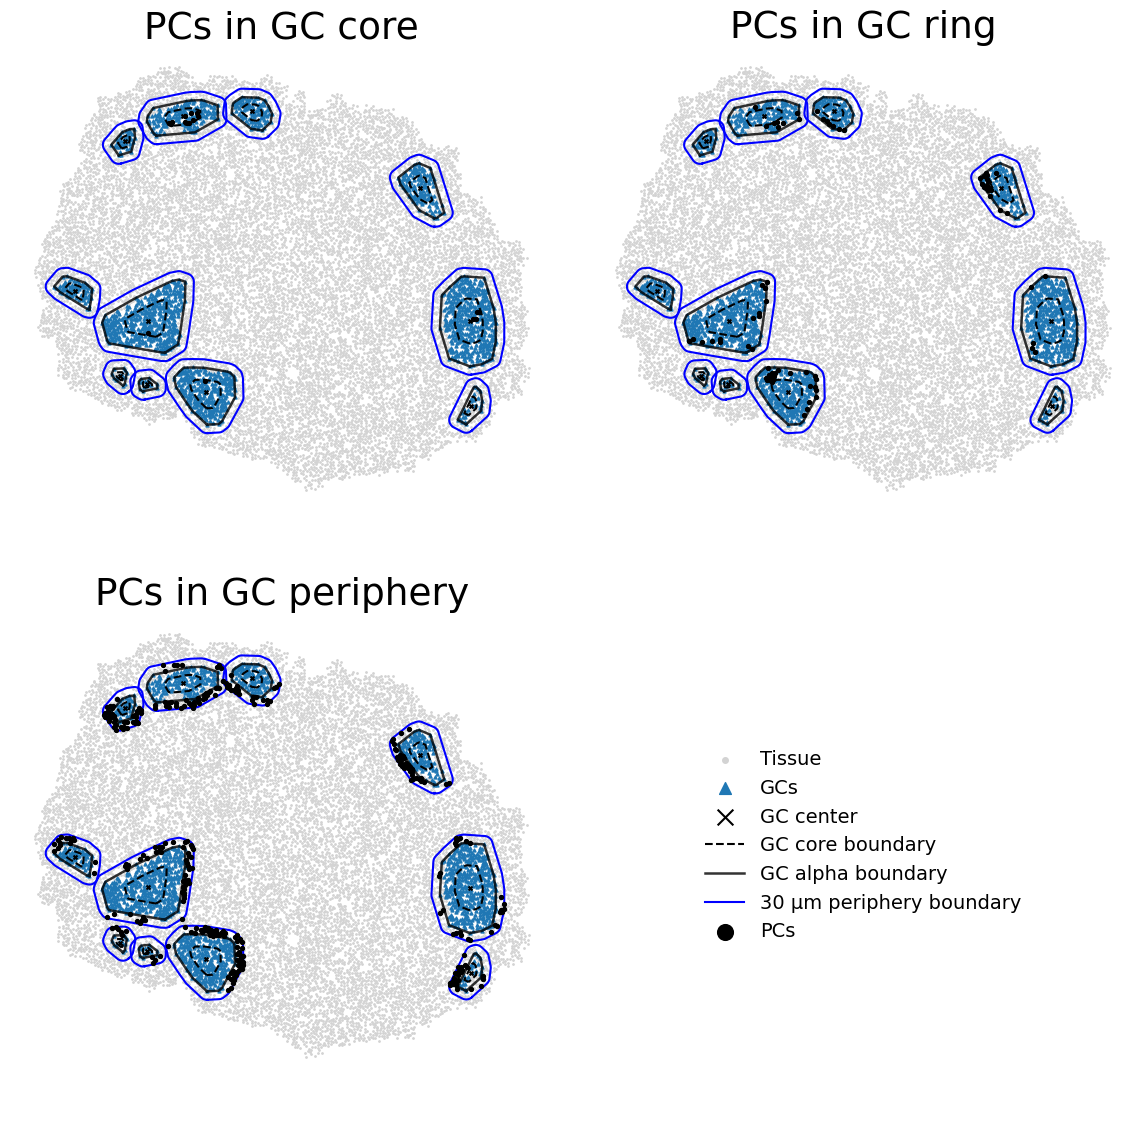

In [64]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12), sharex=True, sharey=True)
axes = axes.flatten()

def plot_base(ax):
    # Tissue background
    ax.scatter(
        x=C85_33_adata.obs.loc[tissue_mask, "x"],
        y=C85_33_adata.obs.loc[tissue_mask, "y"],
        s=1, color="lightgrey", label="Tissue"
    )
    # GC points
    ax.scatter(
        x=C85_33_adata.obs.loc[valid_gcs, "x"],
        y=C85_33_adata.obs.loc[valid_gcs, "y"],
        s=4.5, c="C0", marker="^", label="GCs"
    )
    # GC centers
    ax.scatter(
        x=gc_centers["GC_center_x"],
        y=gc_centers["GC_center_y"],
        s=8, c="black", marker="x", label="GC center"
    )

    # Core boundaries
    core_label_done = False
    for lab, Bdict in shrunk_bounds.items():
        ext = Bdict["exterior"]
        if ext is not None:
            ax.plot(ext[:, 0], ext[:, 1], lw=1.5, ls="--", color="black",
                    label="GC core boundary" if not core_label_done else None)
            core_label_done = True

    # Alpha boundaries
    alpha_label_done = False
    for lab, B in bounds.items():
        if B is not None:
            ax.plot(B[:, 0], B[:, 1], lw=1.8, color="k", alpha=0.8,
                    label="GC alpha boundary" if not alpha_label_done else None)
            alpha_label_done = True

    # Periphery boundaries
    periphery_label_done = False
    for lab, Bdict in outer_bounds.items():
        ext = Bdict["exterior"]
        if ext is not None:
            ax.plot(ext[:, 0], ext[:, 1], lw=1.5, ls="-", color="blue",
                    label="30 µm periphery boundary" if not periphery_label_done else None)
            periphery_label_done = True

    ax.axis("off")
    ax.set_aspect("equal", adjustable="box")


# PCs in core 
plot_base(axes[0])
if not core_df.empty:
    axes[0].scatter(core_df["x"], core_df["y"], s=8, c="black", label="PCs", zorder=3)
axes[0].set_title("PCs in GC core")

# PCs in ring
plot_base(axes[1])
if not ring_df.empty:
    axes[1].scatter(ring_df["x"], ring_df["y"], s=8, c="black", label="PCs", zorder=3)
axes[1].set_title("PCs in GC ring")

# PCs in periphery
plot_base(axes[2])
if not periphery_df.empty:
    axes[2].scatter(periphery_df["x"], periphery_df["y"], s=8, c="black", label="PCs", zorder=3)
axes[2].set_title("PCs in GC periphery")

axes[3].axis("off")  # turn off the plotting area
handles, labels = axes[0].get_legend_handles_labels()
axes[3].legend(handles, labels, loc="center", frameon=False, fontsize=14, markerscale=4)

fig.savefig("pcs_core_ring_periphery.pdf", bbox_inches="tight")

plt.tight_layout()
plt.show()

## C85_32 (d8 min1)

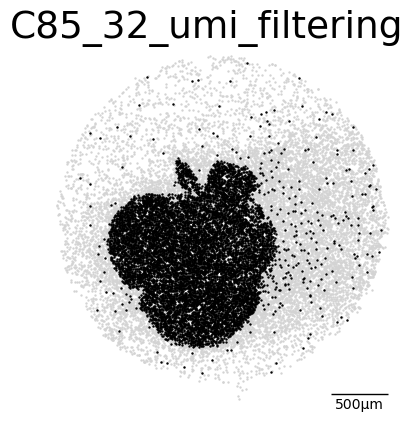

Figure saved as: c85_32_umi_filtering.png


<Figure size 640x480 with 0 Axes>

In [58]:
points, umi_mask, x_all, y_all = umi_filtering(C85_32_adata, "C85_32_umi_filtering")

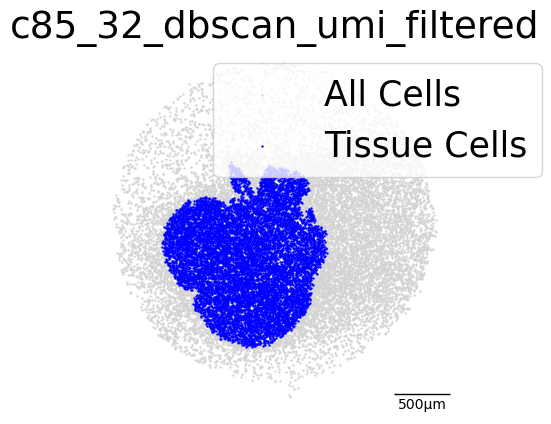

In [59]:
dbscan_filtering(C85_32_adata, points, umi_mask, x_all, y_all, eps=45, fig_title="c85_32_dbscan_umi_filtered")

In [60]:
dilated_indices = dilate_tissue(C85_32_adata, max_itr=25, proportion=0.5)

index_labels = C85_32_adata.obs.iloc[list(dilated_indices)].index
C85_32_adata.obs.loc[index_labels, "Tissue"] = "True"

Original tissue cells: 9257
Tissue cells after dilation: 11777
Added cells: 2520 (27.22% increase)


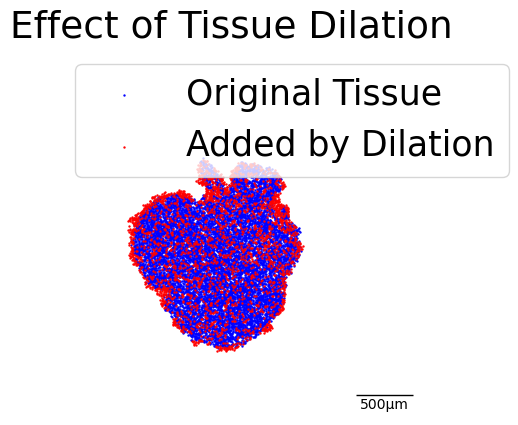

Figure saved as: c85_32_dilated_tissue.png


<Figure size 640x480 with 0 Axes>

In [61]:
plot_tissue(C85_32_adata, fig_title="c85_32_dilated_tissue")

Plotted 471 cells of type PC
Plotted 552 cells of type GCBC
Plotted 463 cells of type NBC
Plotted 232 cells of type MBC
Figure saved as: b_cells_in_tissue.png


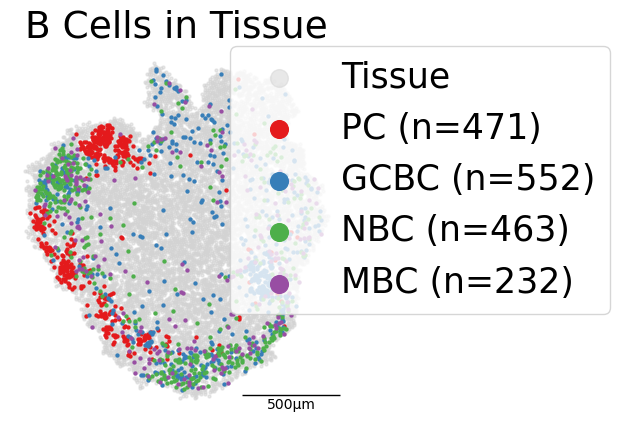

Plotted 471 cells of type PC
Plotted 552 cells of type GCBC
Plotted 463 cells of type NBC
Plotted 232 cells of type MBC
Plotted 2259 cells of type Cytotoxic
Plotted 240 cells of type Epithelial
Plotted 861 cells of type CD4
Plotted 1695 cells of type myeloid
Plotted 2317 cells of type FDC
Plotted 35 cells of type Tfr
Plotted 81 cells of type Tfh
Plotted 88 cells of type PDC
Figure saved as: all_cell_types_in_tissue.png


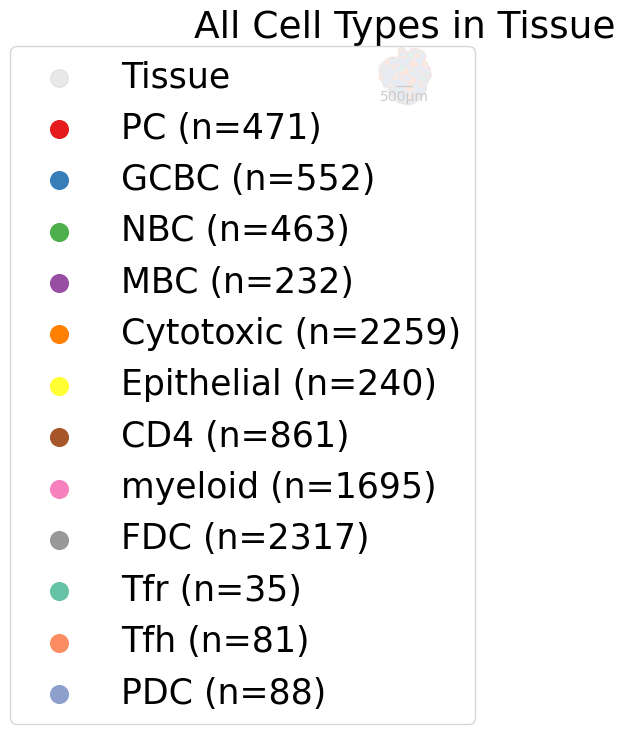

In [62]:
cell_type_colors = {
    "PC": "#e41a1c", 
    "GCBC": "#377eb8",  # Blue
    "NBC": "#4daf4a",  # Green
    "MBC": "#984ea3",  # Purple
    "Cytotoxic": "#ff7f00",  # Orange
    "Epithelial": "#ffff33",  # Yellow
    "CD4": "#a65628",  # Brown
    "myeloid": "#f781bf",  # Pink
    "FDC": "#999999",  # Gray
    "Tfr": "#66c2a5",  # Mint
    "Tfh": "#fc8d62",  # Salmon
    "PDC": "#8da0cb",  # Light blue
}

fig1, ax1 = plot_cell_types(
    C85_32_adata,
    specific_types=["PC", "GCBC", "NBC", "MBC"],
    color_dict=cell_type_colors,
    fig_title="B Cells in Tissue"
)

fig2, ax2 = plot_cell_types(
    C85_32_adata,
    specific_types=[
        "PC",
        "GCBC",
        "NBC",
        "MBC",
        "Cytotoxic",
        "Epithelial",
        "CD4",
        "myeloid",
        "FDC",
        "Tfr",
        "Tfh",
        "PDC",
    ],
    color_dict=cell_type_colors,
    fig_title="All Cell Types in Tissue"
)

In [63]:
create_gc_mask(C85_32_adata)

In [64]:
dbscan_gc_filtering(C85_32_adata, eps = 55)

dilated_indices = dilate_gcs(C85_32_adata, max_itr=15, proportion=0.5)

index_labels = C85_32_adata.obs.iloc[list(dilated_indices)].index

C85_32_adata.obs.loc[index_labels, "GC"] = "True"

went through 6 iterations


Original GC cell #: 132
GC cells # after dilation: 195
Added cells: 63 (47.73% increase)


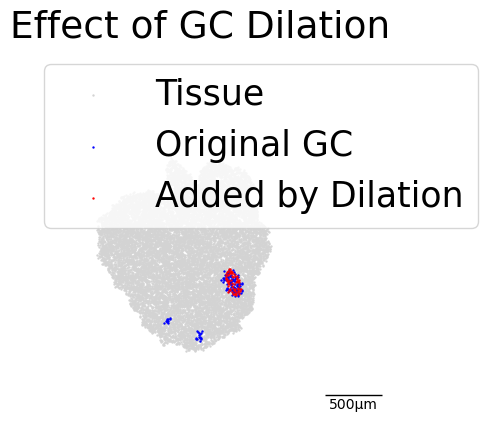

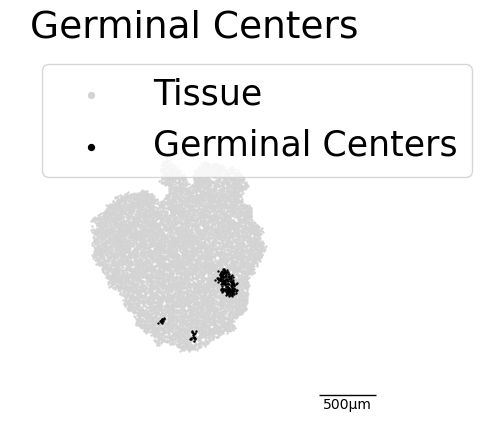

In [65]:
plot_dilated_gcs(C85_32_adata)
plot_gcs(C85_32_adata)

In [66]:
create_pc_mask(C85_32_adata)

Identified 418 plasma cells in tissue.
PCGC == 'True' (PC and GC True): 2 (0.01%)
PCGC == 'False' (PC True, GC False): 416 (1.94%)
PCGC == 'NA' (all other cases): 21067 (98.05%)
Identified 207 GCBCs that are not plasma cells.


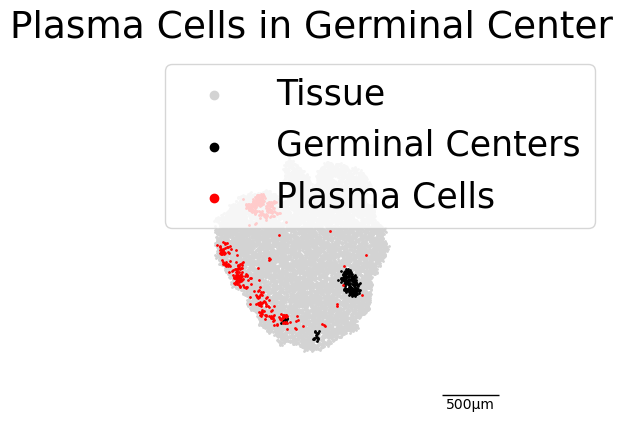

Total Plasma Cells: 418
Total Germinal Center cells: 195
Plasma Cells in Germinal Centers: 2 (0.5% of all PCs)
Percentage of GC cells that are PCs: 1.0%
Figure saved as: plasma_cells_in_germinal_centers.png


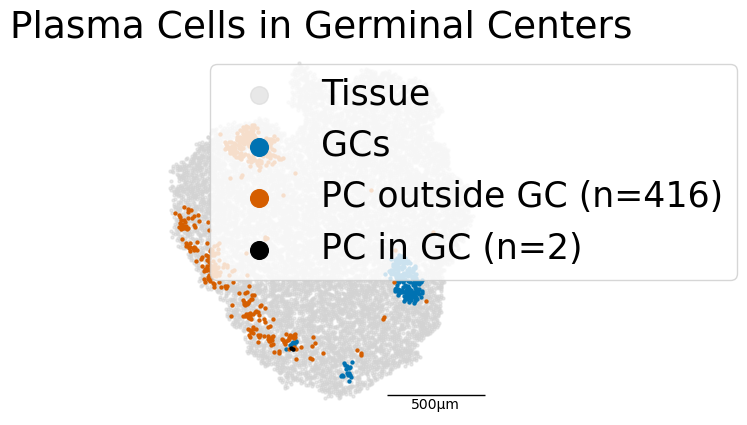

<Figure size 640x480 with 0 Axes>

In [67]:
plot_pcs_in_gcs(C85_32_adata)
plot_pc_gc_distribution(C85_32_adata, fig_title="Plasma Cells in Germinal Centers")

## C85 7 (D6 I3-2)

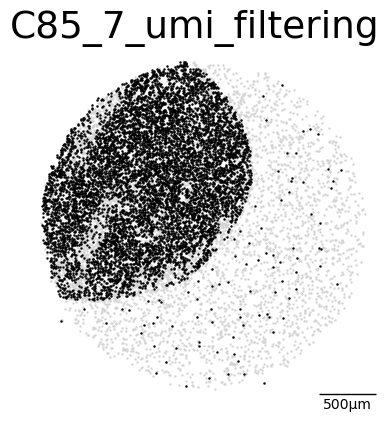

Figure saved as: c85_7_umi_filtering.png


<Figure size 640x480 with 0 Axes>

In [65]:
points, umi_mask, x_all, y_all = umi_filtering(C85_7_adata, "C85_7_umi_filtering")

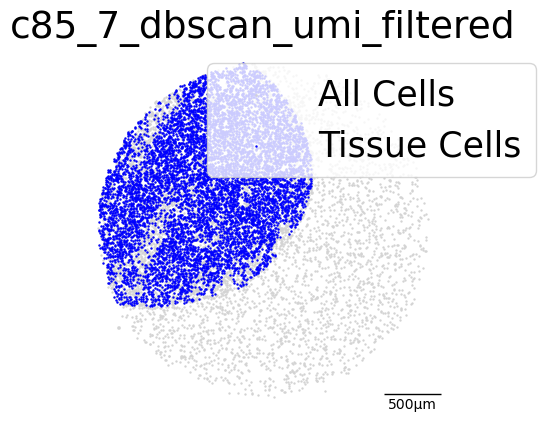

In [66]:
dbscan_filtering(C85_7_adata, points, umi_mask, x_all, y_all, eps=100, fig_title="c85_7_dbscan_umi_filtered")

In [67]:
dilated_indices = dilate_tissue(C85_7_adata, max_itr=20, proportion=0.5)

index_labels = C85_7_adata.obs.iloc[list(dilated_indices)].index
C85_7_adata.obs.loc[index_labels, "Tissue"] = "True"

Original tissue cells: 7909
Tissue cells after dilation: 10832
Added cells: 2923 (36.96% increase)


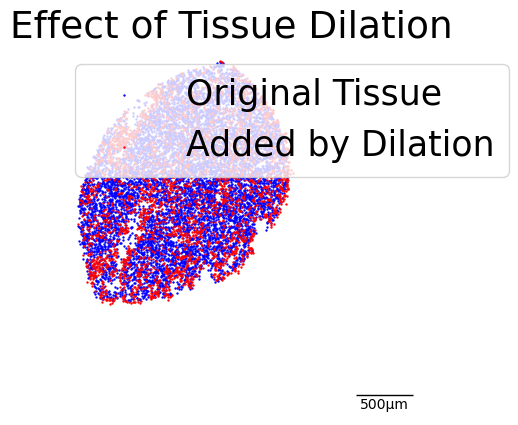

Figure saved as: c85_33_dilated_tissue.png


<Figure size 640x480 with 0 Axes>

In [68]:
plot_tissue(C85_7_adata, fig_title="c85_33_dilated_tissue")

Plotted 2288 cells of type PC
Plotted 942 cells of type GCBC
Plotted 789 cells of type NBC
Plotted 383 cells of type MBC
Figure saved as: b_cells_in_tissue.png


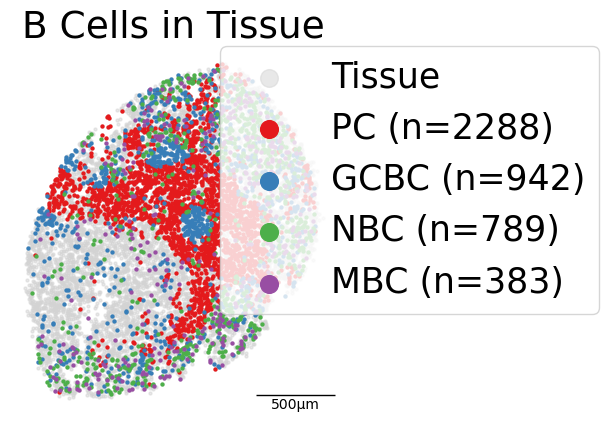

Plotted 2288 cells of type PC
Plotted 942 cells of type GCBC
Plotted 789 cells of type NBC
Plotted 383 cells of type MBC
Plotted 876 cells of type Cytotoxic
Plotted 141 cells of type Epithelial
Plotted 688 cells of type CD4
Plotted 724 cells of type myeloid
Plotted 906 cells of type FDC
Plotted 77 cells of type Tfr
Plotted 74 cells of type Tfh
Plotted 41 cells of type PDC
Figure saved as: all_cell_types_in_tissue.png


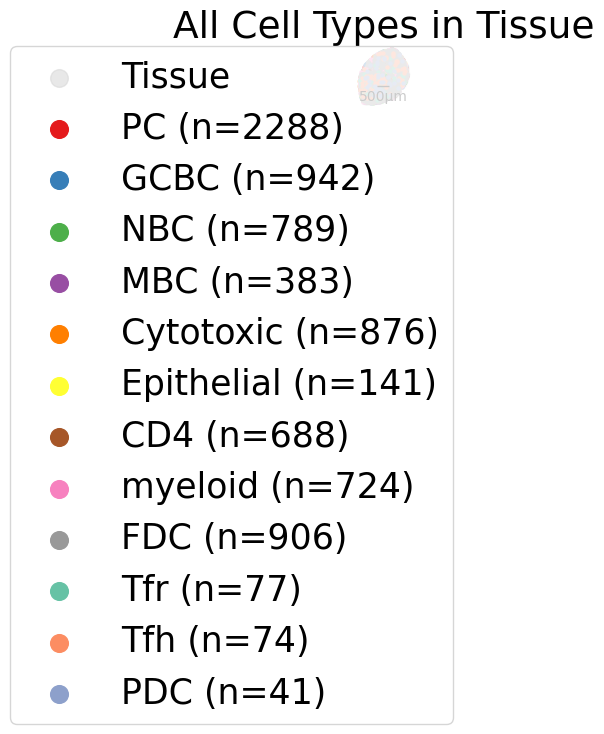

In [69]:
cell_type_colors = {
    "PC": "#e41a1c", 
    "GCBC": "#377eb8",  # Blue
    "NBC": "#4daf4a",  # Green
    "MBC": "#984ea3",  # Purple
    "Cytotoxic": "#ff7f00",  # Orange
    "Epithelial": "#ffff33",  # Yellow
    "CD4": "#a65628",  # Brown
    "myeloid": "#f781bf",  # Pink
    "FDC": "#999999",  # Gray
    "Tfr": "#66c2a5",  # Mint
    "Tfh": "#fc8d62",  # Salmon
    "PDC": "#8da0cb",  # Light blue
}

fig1, ax1 = plot_cell_types(
    C85_7_adata,
    specific_types=["PC", "GCBC", "NBC", "MBC"],
    color_dict=cell_type_colors,
    fig_title="B Cells in Tissue"
)

fig2, ax2 = plot_cell_types(
    C85_7_adata,
    specific_types=[
        "PC",
        "GCBC",
        "NBC",
        "MBC",
        "Cytotoxic",
        "Epithelial",
        "CD4",
        "myeloid",
        "FDC",
        "Tfr",
        "Tfh",
        "PDC",
    ],
    color_dict=cell_type_colors,
    fig_title="All Cell Types in Tissue"
)

In [70]:
create_gc_mask(C85_7_adata)

In [71]:
dbscan_gc_filtering(C85_7_adata, eps = 55)

# Run the dilation function
dilated_indices = dilate_gcs(C85_7_adata, max_itr=15, proportion=0.5)

# Get the index labels corresponding to the numeric indices
index_labels = C85_7_adata.obs.iloc[list(dilated_indices)].index

# Set all these cells to 'True'
C85_7_adata.obs.loc[index_labels, "GC"] = "True"

went through 5 iterations


Original GC cell #: 238
GC cells # after dilation: 323
Added cells: 85 (35.71% increase)


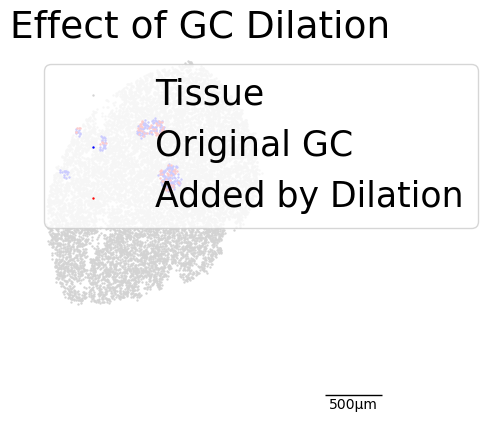

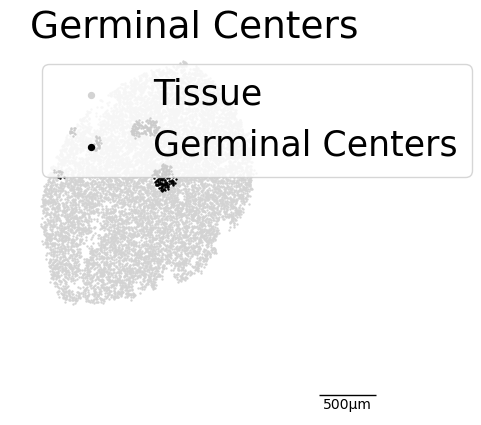

In [72]:
plot_dilated_gcs(C85_7_adata)
plot_gcs(C85_7_adata)

In [73]:
create_pc_mask(C85_7_adata)

Identified 1987 plasma cells in tissue.
PCGC == 'True' (PC and GC True): 31 (0.23%)
PCGC == 'False' (PC True, GC False): 1956 (14.33%)
PCGC == 'NA' (all other cases): 11667 (85.45%)
Identified 415 GCBCs that are not plasma cells.


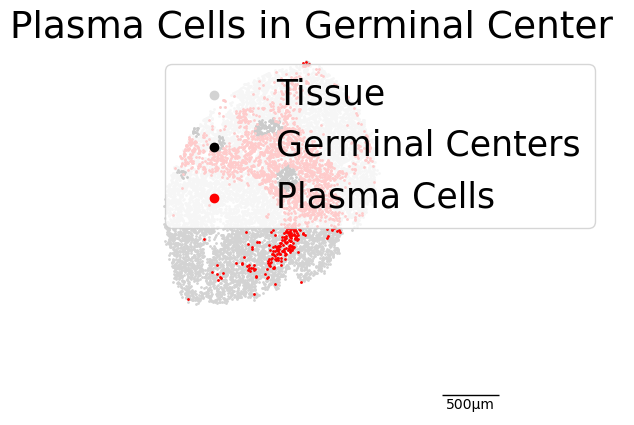

Total Plasma Cells: 1987
Total Germinal Center cells: 323
Plasma Cells in Germinal Centers: 31 (1.6% of all PCs)
Percentage of GC cells that are PCs: 9.6%
Figure saved as: plasma_cells_in_germinal_centers.png


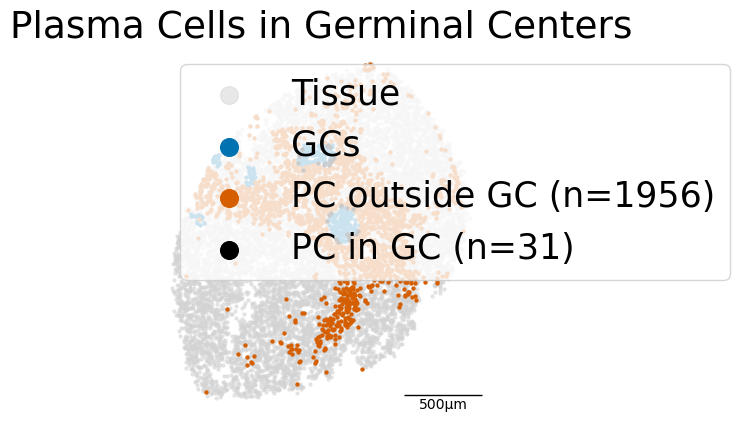

<Figure size 640x480 with 0 Axes>

In [74]:
plot_pcs_in_gcs(C85_7_adata)
plot_pc_gc_distribution(C85_7_adata, fig_title="Plasma Cells in Germinal Centers")

### Distances

In [75]:
stats = assign_gc_id(C85_7_adata, radius=45.0, min_size=5)

In [76]:
# find distance of each point to GC center
valid_gc = C85_7_adata.obs["GC_id"].notna() & (~C85_7_adata.obs["GC_id"].astype(str).str.upper().eq("NA"))
gc_centers = (
    C85_7_adata.obs.loc[valid_gc]
    .groupby("GC_id")[["x", "y"]].mean()
    .rename(columns={"x": "GC_center_x", "y": "GC_center_y"})
)

C85_7_adata.obs = C85_7_adata.obs.merge(gc_centers, left_on="GC_id", right_index=True, how="left")
C85_7_adata.obs["GC_center_dist"] = np.sqrt(
    (C85_7_adata.obs["x"] - C85_7_adata.obs["GC_center_x"])**2
  + (C85_7_adata.obs["y"] - C85_7_adata.obs["GC_center_y"])**2
)
C85_7_adata.obs.loc[~valid_gc, "GC_center_dist"] = np.nan
C85_7_adata.obs

nCount_RNA  nFeature_RNA  numReads  log10_numReads  \
GCACCACTTTAGAG       615.0           386      2049        3.311542   
CATTTAACTTGCTA      2098.0          1235      8817        3.945321   
GCTCATCATTTGTA       390.0           150      1352        3.130977   
CTTTTTCTTAATTC       715.0           501      2703        3.431846   
TCCAGCAACAAATC       373.0           241      1667        3.221936   
...                    ...           ...       ...             ...   
TTCTCTCCTTTCCA        10.0            10        17        1.230449   
TCCTTTTCCCCTTT        11.0            10        19        1.278754   
GCCTCATTTCAACC        10.0             9        14        1.146128   
AACTCCTTCTGGGC        11.0            10        17        1.230449   
GTACTGCGCCACCG        10.0             8        10        1.000000   

                log10_nCount_RNA  log10_nFeature_RNA  pct_rrna  percent.rp  \
GCACCACTTTAGAG          2.788875            2.586587  0.078049    0.017886   
CATTTAACTTGCTA          3.321805            3.091667  0.054337    0.023832   
GCTCATCATTTGTA          2.591065            2.176091  0.110256    0.007692   
CTTTTTCTTAATTC          2.854306            2.699838  0.127273    0.027972   
TCCAGCAACAAATC          2.571709            2.382017  0.142091    0.016086   
...                          ...                 ...       ...         ...   
TTCTCTCCTTTCCA          1.000000            1.000000  0.000000    0.000000   
TCCTTTTCCCCTTT          1.041393            1.000000  0.181818    0.000000   
GCCTCATTTCAACC          1.000000            0.954243  0.200000    0.000000   
AACTCCTTCTGGGC          1.041393            1.000000  0.181818    0.000000   
GTACTGCGCCACCG          1.000000            0.903090  0.000000    0.000000   

                percent.mt  nCount_SCT  ...  Tissue_original     GC  \
GCACCACTTTAGAG    0.003252       268.0  ...             True  False   
CATTTAACTTGCTA    0.001430       138.0  ...             True  False   
GCTCATCATTTGTA    0.002564       251.0  ...             True  False   
CTTTTTCTTAATTC    0.005594       113.0  ...             True  False   
TCCAGCAACAAATC    0.000000       281.0  ...             True  False   
...                    ...         ...  ...              ...    ...   
TTCTCTCCTTTCCA    0.000000        65.0  ...            False  False   
TCCTTTTCCCCTTT    0.000000        85.0  ...            False  False   
GCCTCATTTCAACC    0.000000        82.0  ...            False  False   
AACTCCTTCTGGGC    0.000000        86.0  ...            False  False   
GTACTGCGCCACCG    0.000000        73.0  ...            False  False   

               GC_original     PC  PCGC  GCBC_not_PC GC_id GC_center_x  \
GCACCACTTTAGAG       False  False    NA        False    NA         NaN   
CATTTAACTTGCTA       False  False    NA        False    NA         NaN   
GCTCATCATTTGTA       False  False    NA        False    NA         NaN   
CTTTTTCTTAATTC       False  False    NA        False    NA         NaN   
TCCAGCAACAAATC       False  False    NA        False    NA         NaN   
...                    ...    ...   ...          ...   ...         ...   
TTCTCTCCTTTCCA       False  False    NA        False    NA         NaN   
TCCTTTTCCCCTTT       False  False    NA        False    NA         NaN   
GCCTCATTTCAACC       False  False    NA        False    NA         NaN   
AACTCCTTCTGGGC       False  False    NA        False    NA         NaN   
GTACTGCGCCACCG       False  False    NA        False    NA         NaN   

               GC_center_y GC_center_dist  
GCACCACTTTAGAG         NaN            NaN  
CATTTAACTTGCTA         NaN            NaN  
GCTCATCATTTGTA         NaN            NaN  
CTTTTTCTTAATTC         NaN            NaN  
TCCAGCAACAAATC         NaN            NaN  
...                    ...            ...  
TTCTCTCCTTTCCA         NaN            NaN  
TCCTTTTCCCCTTT         NaN            NaN  
GCCTCATTTCAACC         NaN            NaN  
AACTCCTTCTGGGC         NaN            NaN  
GTACTGCGCCAC

In [77]:
gc_centers = gc_centers.drop(index="NA")
gc_centers

GC_center_x  GC_center_y
GC_id                          
0      2081.270139  3221.725694
1      1825.308000  3891.849600
2      1182.552000  3683.796000
3       664.047143  3279.500000
4       842.750667  3847.500000

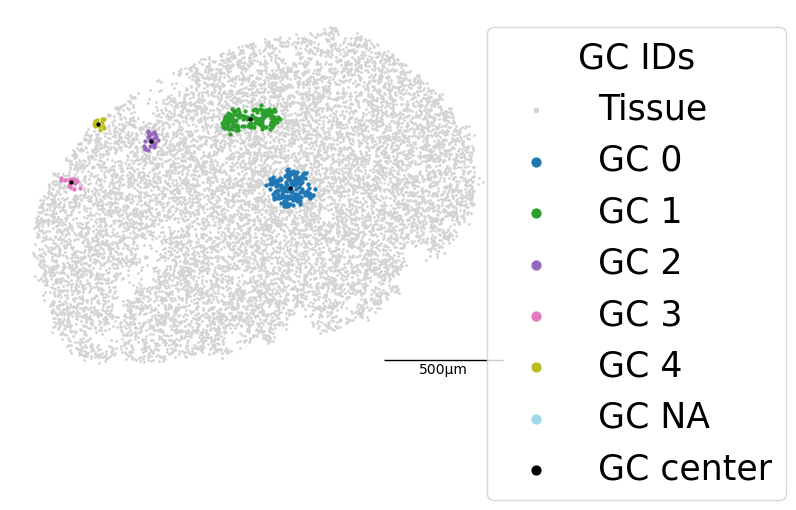

In [78]:
# plot individual GCs
valid_gcs = C85_7_adata.obs["GC_id"].notna() & (~C85_7_adata.obs["GC_id"].str.strip().str.upper().eq("NA"))
tissue_mask = (C85_7_adata.obs["Tissue"] == "True") & (~valid_gcs)

gc_cats = pd.Categorical(C85_7_adata.obs.loc[valid_gcs, "GC_id"])
gc_codes = gc_cats.codes 
cmap = plt.cm.get_cmap("tab20", len(gc_cats.categories))
gc_colors = cmap(gc_codes)

fig, ax = plt.subplots()

# plot tissue as background
ax.scatter(x = C85_7_adata.obs.loc[tissue_mask, "x"],
           y = C85_7_adata.obs.loc[tissue_mask, "y"],
           s=1,
           color = "lightgrey",
           label="Tissue")

for i, cat in enumerate(gc_cats.categories):
    mask = valid_gcs & (C85_7_adata.obs["GC_id"] == cat)
    ax.scatter(
        x=C85_7_adata.obs.loc[mask, "x"],
        y=C85_7_adata.obs.loc[mask, "y"],
        s=4.5,
        color=cmap(i),
        label=f"GC {cat}"
    )

# plot gc centers
ax.scatter(x=gc_centers["GC_center_x"],
           y=gc_centers["GC_center_y"],
           s=4.5,
           c="black",
           label= "GC center")

ax.legend(
    loc="upper right",
    bbox_to_anchor=(1.6, 1),
    markerscale=3,
    title="GC IDs"
)

ax.axis("off")
add_scale_bar(ax)

plt.show()

  label     center_x     center_y  fraction  area_before    area_after
0     0  2081.270139  3221.725694       0.5   79692.8450  19923.211250
1     1  1825.308000  3891.849600       0.5   74561.7150  18640.428750
2     2  1182.552000  3683.796000       0.5   11447.1450   2861.786250
3     3   664.047143  3279.500000       0.5    7748.7470   1937.186750
4     4   842.750667  3847.500000       0.5    5092.7685   1273.192125


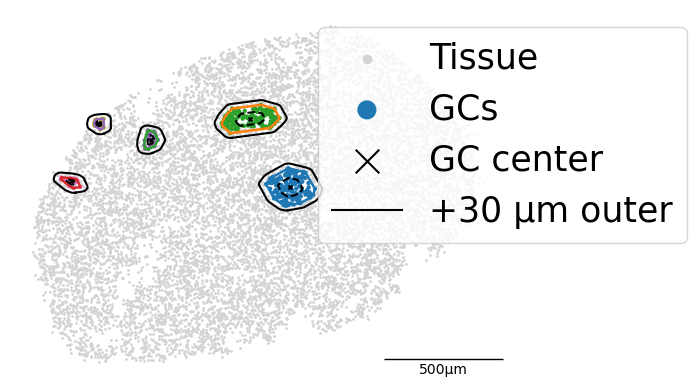

In [80]:
polys, bounds, info = gc_alpha_boundaries(
    C85_7_adata,
    gc_col="GC_id",
    x_col="x", y_col="y",
    alpha=1.5
)
centers = make_centers_dict(gc_centers, drop_na=True)

shrunk_polys, shrunk_bounds, shrink_info = shrink_gc_boundaries(
    polygons=polys,
    centers=centers,
    fraction=0.5
)
print(shrink_info.head())

fig, ax = plt.subplots()

# plot tissue as background
ax.scatter(
    x=C85_7_adata.obs.loc[tissue_mask, "x"],
    y=C85_7_adata.obs.loc[tissue_mask, "y"],
    s=1,
    color="lightgrey",
    label="Tissue"
)

# plot GC points
ax.scatter(
    x=C85_7_adata.obs.loc[valid_gcs, "x"],
    y=C85_7_adata.obs.loc[valid_gcs, "y"],
    s=4.5,
    c=gc_colors,
    label="GCs"
)

# plot GC centers
ax.scatter(
    x=gc_centers["GC_center_x"],
    y=gc_centers["GC_center_y"],
    s=8,
    c="black",
    marker="x",
    label="GC center"
)

# Outer boundaries (already plotted with `bounds`)
for lab, B in bounds.items():
    ax.plot(B[:,0], B[:,1], lw=1.8)

# Inner homothetic boundaries (dashed black)
for lab, Bdict in shrunk_bounds.items():
    ext = Bdict["exterior"]
    if ext is not None:
        ax.plot(ext[:,0], ext[:,1], lw=1.5, ls="--", color="black")
        
        
outer_polys = {lab: outer_boundary_polygon(poly, distance_um=30/0.65)
               for lab, poly in polys.items()}

outer_bounds = {}
for lab, poly in outer_polys.items():
    ext_xy, holes_xy = extract_boundary_coords(poly)
    outer_bounds[lab] = {"exterior": ext_xy, "holes": holes_xy}
for lab, Bdict in outer_bounds.items():
    ext = Bdict["exterior"]
    if ext is not None:
        ax.plot(ext[:,0], ext[:,1], lw=1.5, ls="-", color="black", label="+30 µm outer" if lab == list(outer_bounds.keys())[0] else None)

        
        
ax.axis("off")
add_scale_bar(ax)
ax.legend(loc="upper right", bbox_to_anchor=(1.4, 1), markerscale=6)

plt.show()

Per-GC Fisher exact tests (core vs ring):
  GC 1: p = 0.0127 [n=125; core PC=0, ring PC=16]
  GC 0: p = 0.0138 [n=144; core PC=0, ring PC=15]

Fisher’s method (combined across GCs):
  chi2_stat = 17.3, combined p = 0.00169
Figure saved as: inner_vs_outer_gcs.png


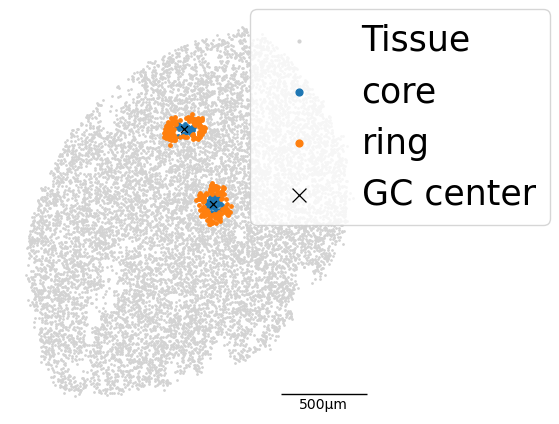

In [81]:
summary, meta, core_df, ring_df = fisher_core_vs_ring_overlay(
    adata=C85_7_adata,
    polygons=polys,
    shrunk_polys=shrunk_polys,
    gc_centers=gc_centers,
    gc_col="GC_id",
    pc_col="PCGC",
    min_size=100,
    plot=True,
    fig_title="inner_vs_outer_gcs"
)

  label     center_x     center_y  fraction  area_before    area_after
0     0  2081.270139  3221.725694       0.5   79692.8450  19923.211250
1     1  1825.308000  3891.849600       0.5   74561.7150  18640.428750
2     2  1182.552000  3683.796000       0.5   11447.1450   2861.786250
3     3   664.047143  3279.500000       0.5    7748.7470   1937.186750
4     4   842.750667  3847.500000       0.5    5092.7685   1273.192125


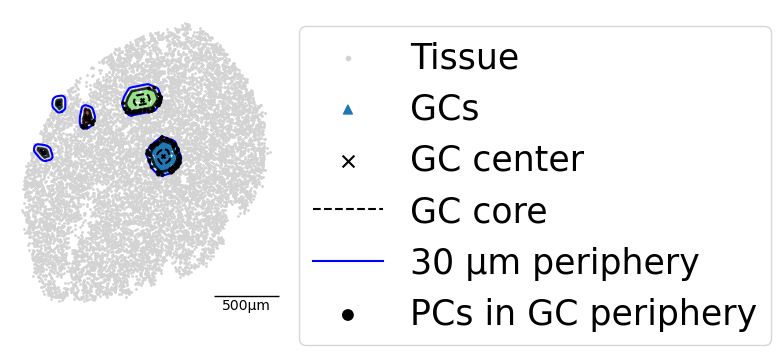

  GC_id  n_PC_in_periphery
0     0                 54
1     1                 33
2     2                  7
3     3                  0
4     4                  0


In [83]:
polys, bounds, info = gc_alpha_boundaries(
    C85_7_adata,
    gc_col="GC_id",
    x_col="x", y_col="y",
    alpha=1.5
)

centers = make_centers_dict(gc_centers, drop_na=True)

shrunk_polys, shrunk_bounds, shrink_info = shrink_gc_boundaries(
    polygons=polys,
    centers=centers,
    fraction=0.5
)
print(shrink_info.head())

outer_polys = {lab: outer_boundary_polygon(poly, distance_um=30/0.65, join=1)
               for lab, poly in polys.items()}

outer_bounds = {}
for lab, poly in outer_polys.items():
    ext_xy, holes_xy = extract_boundary_coords(poly)
    outer_bounds[lab] = {"exterior": ext_xy, "holes": holes_xy}

per_counts, per_idx = pcs_around_gc(
    C85_7_adata,
    polygons=polys,
    pc_col="PCGC",
    dist_pixels=30/0.65,
    x_col="x",
    y_col="y",
    include_boundaries=True,
    return_indices=True
)

# Combine periphery PC coordinates for plotting
periphery_rows = []
for gid, idx_list in per_idx.items():
    if not idx_list:
        continue
    sub = C85_7_adata.obs.loc[idx_list, ["x", "y"]].copy()
    sub["GC_id"] = gid
    periphery_rows.append(sub)
periphery_df = pd.concat(periphery_rows, ignore_index=True) if periphery_rows else pd.DataFrame(columns=["x","y","GC_id"])

# GC masks & colors
valid_gcs = C85_7_adata.obs["GC_id"].notna() & (~C85_7_adata.obs["GC_id"].astype(str).str.strip().str.upper().eq("NA"))
tissue_mask = (C85_7_adata.obs["Tissue"].astype(str).str.lower() == "true") & (~valid_gcs)

gc_cats = pd.Categorical(C85_7_adata.obs.loc[valid_gcs, "GC_id"].astype(str))
gc_codes = gc_cats.codes
cmap = plt.cm.get_cmap("tab20", len(gc_cats.categories))
gc_colors = cmap(gc_codes)

fig, ax = plt.subplots(figsize=(8, 8))

# tissue background
ax.scatter(
    x=C85_7_adata.obs.loc[tissue_mask, "x"],
    y=C85_7_adata.obs.loc[tissue_mask, "y"],
    s=1,
    color="lightgrey",
    label="Tissue"
)

# GC points
ax.scatter(
    x=C85_7_adata.obs.loc[valid_gcs, "x"],
    y=C85_7_adata.obs.loc[valid_gcs, "y"],
    s=4.5,
    c=gc_colors,
    marker="^",
    label="GCs"
)

# GC centers
ax.scatter(
    x=gc_centers["GC_center_x"],
    y=gc_centers["GC_center_y"],
    s=8,
    c="black",
    marker="x",
    label="GC center"
)

# Outer alpha-shape boundaries
for lab, B in bounds.items():
    if B is not None:
        ax.plot(B[:, 0], B[:, 1], lw=1.8, color="k", alpha=0.8)

# Inner shrunk boundaries (dashed)
first_label_done=False
for lab, Bdict in shrunk_bounds.items():
    ext = Bdict["exterior"]
    if ext is not None:
        ax.plot(ext[:, 0], ext[:, 1], lw=1.5, ls="--", color="black", label = "GC core" if not first_label_done else None)
        first_label_done=True

# +30 µm outer boundaries
first_label_done = False
for lab, Bdict in outer_bounds.items():
    ext = Bdict["exterior"]
    if ext is not None:
        ax.plot(
            ext[:, 0], ext[:, 1],
            lw=1.5, ls="-", color="blue",
            label="30 µm periphery" if not first_label_done else None
        )
        first_label_done = True

# PCs in the 30 µm ring
if not periphery_df.empty:
    ax.scatter(
        periphery_df["x"], periphery_df["y"],
        s=8, c="black", edgecolors="none",
        label="PCs in GC periphery", zorder=3
    )

ax.axis("off")
ax.set_aspect("equal", adjustable="box")
add_scale_bar(ax)
ax.legend(loc="upper left", bbox_to_anchor=(1, 1), borderaxespad=0.5, markerscale=3)
plt.tight_layout()
plt.show()

print(per_counts)

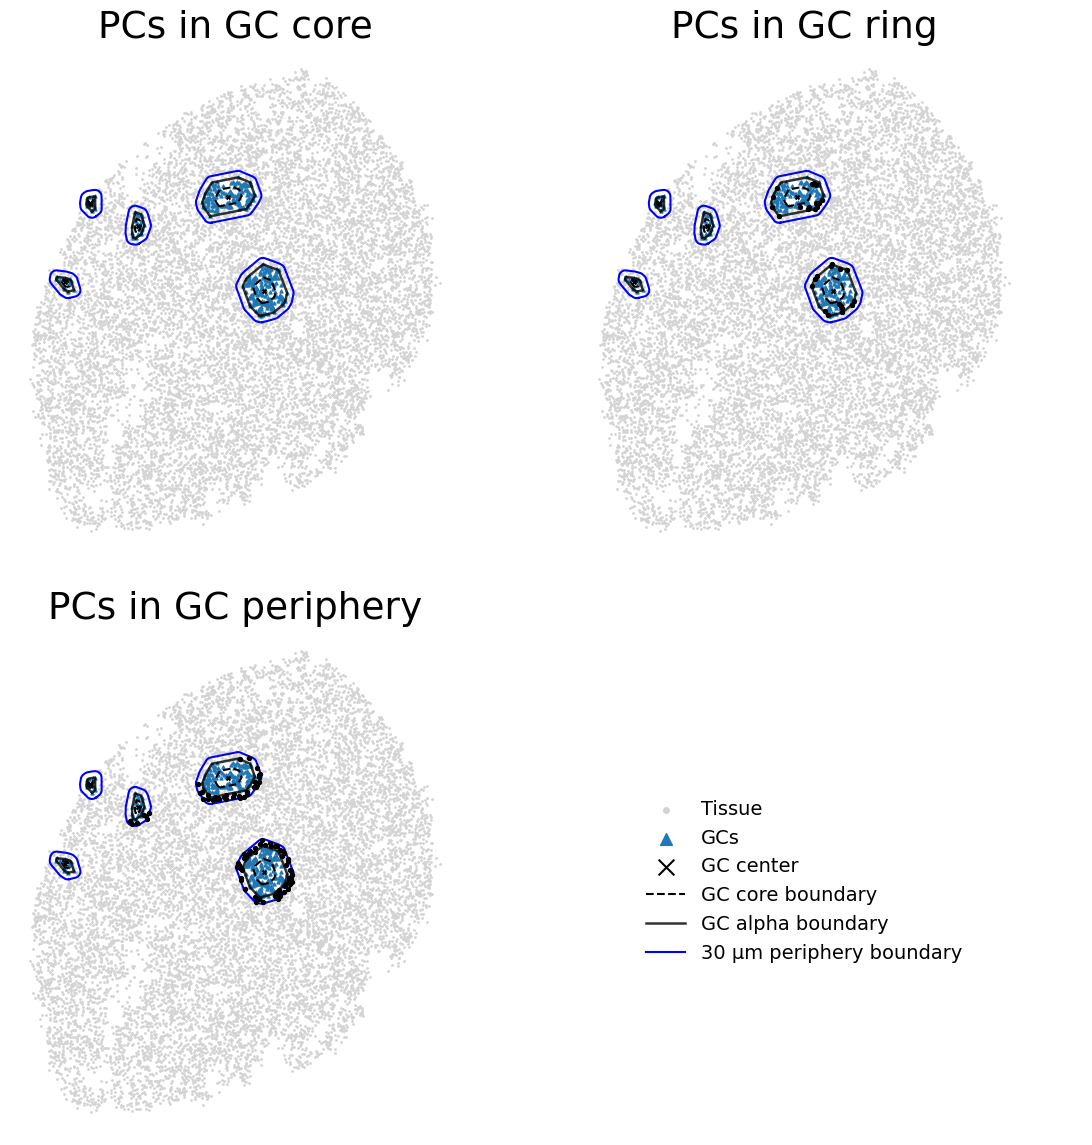

In [84]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12), sharex=True, sharey=True)
axes = axes.flatten()

def plot_base(ax):
    # Tissue background
    ax.scatter(
        x=C85_7_adata.obs.loc[tissue_mask, "x"],
        y=C85_7_adata.obs.loc[tissue_mask, "y"],
        s=1, color="lightgrey", label="Tissue"
    )
    # GC points
    ax.scatter(
        x=C85_7_adata.obs.loc[valid_gcs, "x"],
        y=C85_7_adata.obs.loc[valid_gcs, "y"],
        s=4.5, c="C0", marker="^", label="GCs"
    )
    # GC centers
    ax.scatter(
        x=gc_centers["GC_center_x"],
        y=gc_centers["GC_center_y"],
        s=8, c="black", marker="x", label="GC center"
    )

    # Core boundaries
    core_label_done = False
    for lab, Bdict in shrunk_bounds.items():
        ext = Bdict["exterior"]
        if ext is not None:
            ax.plot(ext[:, 0], ext[:, 1], lw=1.5, ls="--", color="black",
                    label="GC core boundary" if not core_label_done else None)
            core_label_done = True

    # Alpha boundaries
    alpha_label_done = False
    for lab, B in bounds.items():
        if B is not None:
            ax.plot(B[:, 0], B[:, 1], lw=1.8, color="k", alpha=0.8,
                    label="GC alpha boundary" if not alpha_label_done else None)
            alpha_label_done = True

    # Periphery boundaries
    periphery_label_done = False
    for lab, Bdict in outer_bounds.items():
        ext = Bdict["exterior"]
        if ext is not None:
            ax.plot(ext[:, 0], ext[:, 1], lw=1.5, ls="-", color="blue",
                    label="30 µm periphery boundary" if not periphery_label_done else None)
            periphery_label_done = True

    ax.axis("off")
    ax.set_aspect("equal", adjustable="box")


# PCs in core 
plot_base(axes[0])
if not core_df.empty:
    axes[0].scatter(core_df["x"], core_df["y"], s=8, c="black", label="PCs", zorder=3)
axes[0].set_title("PCs in GC core")

# PCs in ring
plot_base(axes[1])
if not ring_df.empty:
    axes[1].scatter(ring_df["x"], ring_df["y"], s=8, c="black", label="PCs", zorder=3)
axes[1].set_title("PCs in GC ring")

# PCs in periphery
plot_base(axes[2])
if not periphery_df.empty:
    axes[2].scatter(periphery_df["x"], periphery_df["y"], s=8, c="black", label="PCs", zorder=3)
axes[2].set_title("PCs in GC periphery")

axes[3].axis("off")  # turn off the plotting area
handles, labels = axes[0].get_legend_handles_labels()
axes[3].legend(handles, labels, loc="center", frameon=False, fontsize=14, markerscale=4)

fig.savefig("pcs_core_ring_periphery.pdf", bbox_inches="tight")

plt.tight_layout()
plt.show()

## C85 14 (D8 min2)

In [ ]:
points, umi_mask, x_all, y_all = umi_filtering(C85_14_adata, "C85_14_umi_filtering")

In [ ]:
dbscan_filtering(C85_14_adata, points, umi_mask, x_all, y_all, eps=150, fig_title="c85_14_dbscan_umi_filtered")

In [ ]:
dilated_indices = dilate_tissue(C85_14_adata, max_itr=20, proportion=0.5)

index_labels = C85_14_adata.obs.iloc[list(dilated_indices)].index
C85_14_adata.obs.loc[index_labels, "Tissue"] = "True"

In [ ]:
plot_tissue(C85_14_adata, fig_title="c85_14_dilated_tissue")

In [ ]:
cell_type_colors = {
    "PC": "#e41a1c", 
    "GCBC": "#377eb8",  # Blue
    "NBC": "#4daf4a",  # Green
    "MBC": "#984ea3",  # Purple
    "Cytotoxic": "#ff7f00",  # Orange
    "Epithelial": "#ffff33",  # Yellow
    "CD4": "#a65628",  # Brown
    "myeloid": "#f781bf",  # Pink
    "FDC": "#999999",  # Gray
    "Tfr": "#66c2a5",  # Mint
    "Tfh": "#fc8d62",  # Salmon
    "PDC": "#8da0cb",  # Light blue
}

fig1, ax1 = plot_cell_types(
    C85_14_adata,
    specific_types=["PC", "GCBC", "NBC", "MBC"],
    color_dict=cell_type_colors,
    fig_title="B Cells in Tissue"
)

fig2, ax2 = plot_cell_types(
    C85_14_adata,
    specific_types=[
        "PC",
        "GCBC",
        "NBC",
        "MBC",
        "Cytotoxic",
        "Epithelial",
        "CD4",
        "myeloid",
        "FDC",
        "Tfr",
        "Tfh",
        "PDC",
    ],
    color_dict=cell_type_colors,
    fig_title="All Cell Types in Tissue"
)

In [ ]:
create_gc_mask(C85_14_adata)

In [ ]:
dbscan_gc_filtering(C85_14_adata, eps = 55)

# Run the dilation function
dilated_indices = dilate_gcs(C85_14_adata, max_itr=15, proportion=0.5)

# Get the index labels corresponding to the numeric indices
index_labels = C85_14_adata.obs.iloc[list(dilated_indices)].index

# Set all these cells to 'True'
C85_14_adata.obs.loc[index_labels, "GC"] = "True"

In [ ]:
plot_dilated_gcs(C85_14_adata)
plot_gcs(C85_14_adata)

In [ ]:
create_pc_mask(C85_14_adata)

In [ ]:
plot_pcs_in_gcs(C85_14_adata)
plot_pc_gc_distribution(C85_14_adata, fig_title="Plasma Cells in Germinal Centers")